In [1]:
using LinearAlgebra
using SparseArrays
using Random
using CairoMakie
using Statistics
using DynamicalSystemsBase
using ProgressMeter
using DataFrames
using StatsBase

In [2]:
# total_time = 300
# time_delta = 0.01
# ts_str = ["x", "y", "z"]
# init_conds = [-15.0,-15.0,10.0]
# lo_variables = [10, 8/3, 28]
# init_time_to_ignore = 10

total_time = 100
time_delta = 0.05
ts_str = ["x", "y", "z"]
init_conds = [-15.0,-15.0,10.0]
lo_variables = [10, 8/3, 28]
init_time_to_ignore = 10

10

In [3]:
function Lorenz(u, p, t)
    σ = p[1]
    β = p[2]
    ρ = p[3]

    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]

    return SVector(du1, du2, du3)
end

Lorenz (generic function with 1 method)

In [4]:
lo = CoupledODEs(Lorenz, init_conds, lo_variables)
lo_tr, tvec = trajectory(lo, total_time; Δt = time_delta, Ttr = init_time_to_ignore)

(3-dimensional StateSpaceSet{Float64} with 2001 points, 10.0:0.05:110.0)

In [5]:
function SplitSet(set, ratio)
    split_point = trunc(Int, ratio*length(set))
    train_set = set[1:split_point]
    test_set = set[split_point+1:length(set)]
    
    return(train_set, test_set)
end

SplitSet (generic function with 1 method)

In [6]:
lo_train, lo_test = SplitSet(lo_tr[:,1], 0.8)

([5.126534053596909, 5.834707413699581, 6.991808357426451, 8.530218492050775, 10.224320148458034, 11.579262391541565, 11.948150768409606, 11.02325560795919, 9.2017949533067, 7.247977130696019  …  -5.887519399658594, -4.697712806000977, -4.167693304685385, -4.204074611701369, -4.7382169415983375, -5.75633119046645, -7.266601502534731, -9.196778775001327, -11.208123093355411, -12.55656884076569], [-12.415986260210136, -10.699034002989672, -8.254351347933396, -6.044253634260853, -4.531298519257201, -3.7493889811347816, -3.5777245849602233, -3.9118587789448065, -4.719787809392619, -6.032461031819949  …  4.078660160549764, 5.962537286963292, 8.668699915006643, 12.026848724461564, 14.875646229512645, 15.106724888663642, 12.02703738961137, 7.627029096797196, 3.9600454922802943, 1.5954928708088183])

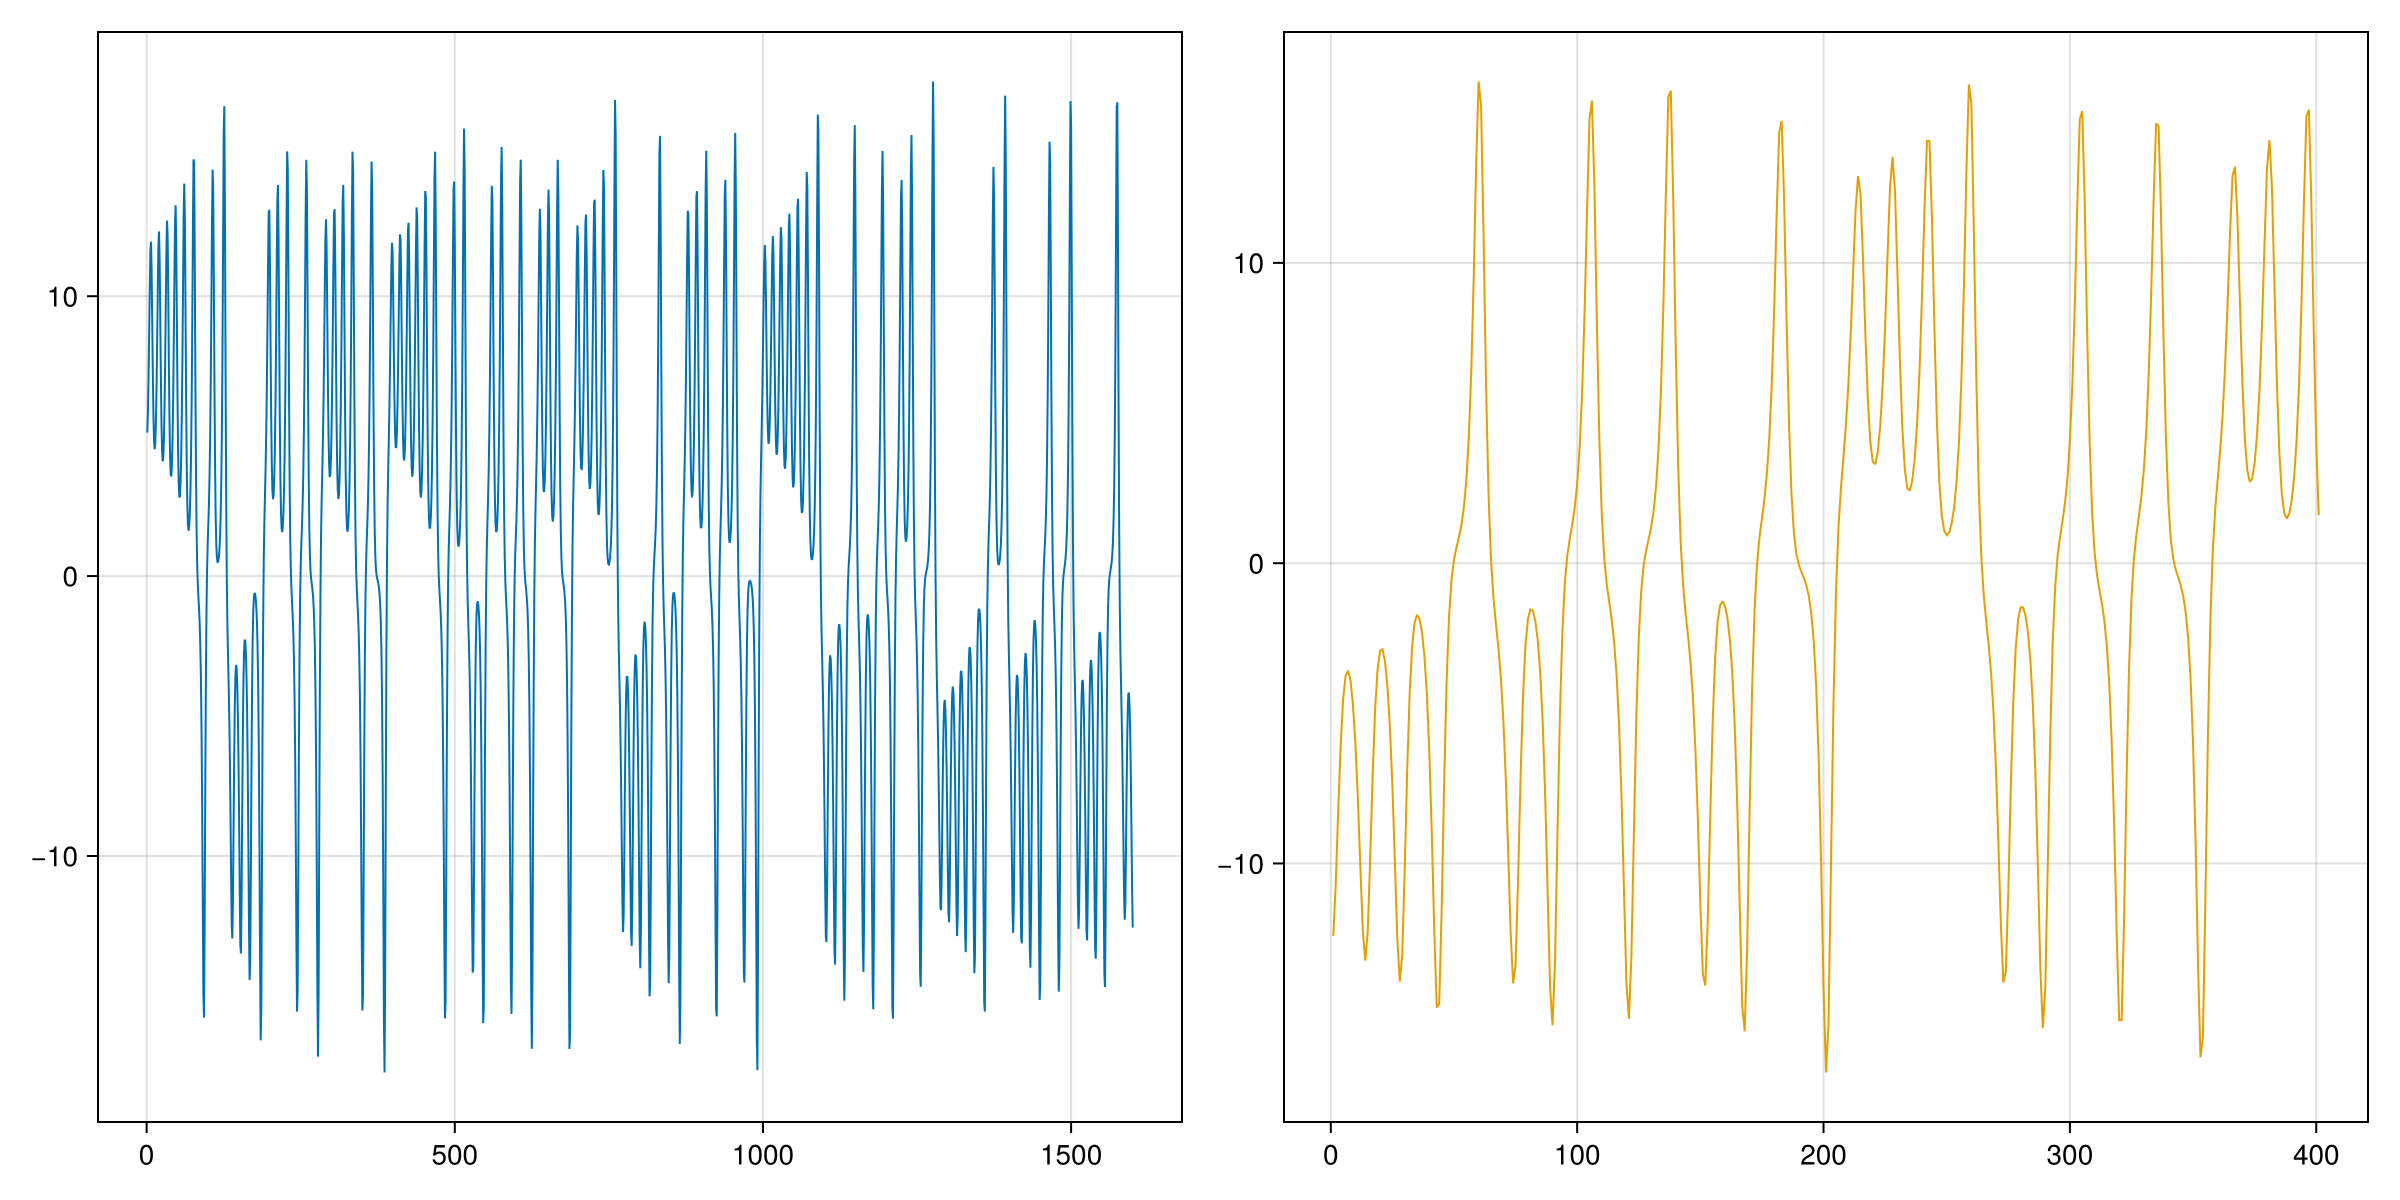

In [58]:
fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [7]:
function erdos_renyi_adjacency(k, d)
    p = d/(k-1)
    adj_mat = triu(collect(sprand(k, k, p)))
    adj_mat = adj_mat + adj_mat'
    adj_mat[diagind(adj_mat)] .= 0
    return(adj_mat)
end

function create_ESN(k, d, ρ)
    V_in = randn(k)
    
    V_rec = erdos_renyi_adjacency(k, d)
    max_abs_ev = maximum(abs.(eigen(V_rec).values))
    V_rec = V_rec * ρ / max_abs_ev
    
    V_bias = randn(k)
    
    return(V_in, V_rec, V_bias)
end

struct ESNParameters
    V_in::Vector{Float64}
    V_rec::Matrix{Float64}
    V_bias::Vector{Float64}
    k::Int64
    α::Float64
    η::Float64
    β::Float64
end

function create_ESN_params(k, d, ρ, α, η, β)
    V_in, V_rec, V_bias = create_ESN(k, d, ρ)
    ESN_params = ESNParameters(V_in, V_rec, V_bias, k, α, η, β)
    
    return(ESN_params)
end

create_ESN_params (generic function with 1 method)

In [60]:
test_mat = erdos_renyi_adjacency(5, 2)

5×5 Matrix{Float64}:
 0.0       0.536568  0.166771  0.0       0.0
 0.536568  0.0       0.0       0.71562   0.0
 0.166771  0.0       0.0       0.599274  0.0
 0.0       0.71562   0.599274  0.0       0.0
 0.0       0.0       0.0       0.0       0.0

In [61]:
test_mat

5×5 Matrix{Float64}:
 0.0       0.536568  0.166771  0.0       0.0
 0.536568  0.0       0.0       0.71562   0.0
 0.166771  0.0       0.0       0.599274  0.0
 0.0       0.71562   0.599274  0.0       0.0
 0.0       0.0       0.0       0.0       0.0

In [8]:
function run_ESN(x, ESN_params; S = nothing)
    if S == nothing
        S = randn(ESN_params.k)
    end
    
    states = zeros(Float64, ESN_params.k, length(x))
    
    for t in 1:length(x)
        S = (1 − ESN_params.α)*S + ESN_params.α*tanh.(
            ESN_params.η*ESN_params.V_in*x[t] + ESN_params.V_rec*S + ESN_params.V_bias)
        states[:, t] = S
    end
    
    return(states')
end

run_ESN (generic function with 1 method)

In [9]:
using LinearAlgebra

function ridge_regression(x::Vector, states::Matrix, beta::Float64)
    # Ensure states is a matrix and x is a vector
    @assert size(states, 1) == length(x)
    
    # Compute the number of features
    n_features = size(states, 2)
    
    # Compute the identity matrix of size n_features
    I_test = Matrix{Float64}(I, n_features, n_features)
    
    # Compute the Ridge regression solution
    R = (states' * states + beta * I_test) \ (states' * x)
    
    return R
end

# Example usage
# states = [1.0 2.0; 3.0 4.0; 5.0 6.0]
# x = [1.0, 2.0, 3.0]
# lambda = 0.1

# R = ridge_regression(x, states, lambda)

ridge_regression (generic function with 1 method)

In [10]:
function train_one_step_pred(x, ESN_params)
    states = run_ESN(x, ESN_params)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

In [66]:
function calculate_corr_coeffs(ESN_params, max_τ, x_length)
    u_train = randn(x_length)
    u_test = randn(x_length)
    corr_coeffs = zeros(max_τ+1)
    states_train = run_ESN(u_train, ESN_params)
    states_test = run_ESN(u_test, ESN_params)
    
    train_time = 0
    test_time = 0
    mse = 0

    for delay in 0:1:max_τ
        
        # Train an R for remembering the input 'delay' steps ago
        states_train_later = states_train[1+delay:size(states_train)[1],:]
        u_train_earlier = u_train[1:length(u_train)-delay]
        
        beginning_time = time_ns()

        R = ridge_regression(u_train_earlier, states_train_later, ESN_params.β)
        
        train_time += (time_ns()-beginning_time)/1000000
        
        states_test_later = states_test[1+delay:size(states_test)[1],:]
        u_test_earlier = u_test[1:length(u_test)-delay]
        
        beginning_time = time_ns()
        
        # Make the recollections
        test_preds = states_test_later * R
        
        test_time += (time_ns()-beginning_time)/1000000
        
        mse += mean((u_test_earlier-test_preds).^2)
        
        # Save errors (as correlation)
        corr_coeffs[delay+1] = cor(u_test_earlier, test_preds)#^2
    end
    
    println("Average train time: ", train_time/max_τ)
    println("Average test time: ", test_time/max_τ)
    println("MSE: ", mse/max_τ)
    
    return(corr_coeffs)
end

calculate_corr_coeffs (generic function with 1 method)

In [12]:
function find_max_delay(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    return(findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ))
end

find_max_delay (generic function with 1 method)

In [13]:
function plot_memory_capacity(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    MCs = cumsum(corr_coeffs)
    
    fig = Figure( size = (800,400), fonts = (; regular = "Tex"), fontsize = 12)
    lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
    ylims!(-0.1,1.1)
    lines!(Axis(fig[1,2], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
    ylims!(0,maximum(MCs)+1)
    
    println(string(
        "Memory capacity: ",
        findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ)
    ))
    
    return(fig)
end

plot_memory_capacity (generic function with 1 method)

In [14]:
function one_step_errors(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)

    return(cor(lo_test[2:end], preds[1:length(preds)-1]))
end

one_step_errors (generic function with 1 method)

In [15]:
function plot_one_step_test(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)
    
    fig = Figure( size = (1200,600))
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(0,200)
    ylims!(-25,25)
    
    ax1 = Axis(fig[2,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(length(lo_test)-200,length(lo_test))
    ylims!(-25,25)
    display(fig)
    
    println(string("Error (correlation): ", cor(preds[1:end-1], lo_test[2:end])))
end

plot_one_step_test (generic function with 1 method)

In [17]:
k = 100
d = k*0.05
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

ESNParameters([0.058511921029542904, -0.6884110763137072, 1.5446198208911315, -0.905324002249463, 1.9504957932510123, -0.3405459783237874, 2.2844584397471843, -1.5649775271306061, -0.23146254730521076, 0.5015271370481353  …  0.8106162112402236, 0.47386831211155334, -1.3519391307715822, 1.0514661303442472, -1.8719867636227836, -1.066186447031239, 0.2845893720570775, -0.6552186677157319, 0.10247185111868415, 0.6922290173844553], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-1.449007198094123, -0.12959280688336658, 1.2789709695992115, -0.6302196572435269, 0.12288128069175996, -0.06817666079271188, -0.4465971282221847, 1.1505349487364338, -0.21555762185706423, -0.1627332920218688  …  -0.02610822032656445, -1.0551703743720904, 0.26775725353672647, 0.3119827725194791, -0.7006576111094984, -0.5763227824909921, 0.05026195577331161, -0.7265853387958535, 1.3835504793600506, 0.7266831180652013], 100, 1.0, 0.0565917388437432, 0.001)

## One-step Prediction, Correlation (error) and Memory Capacity

Memory capacity: 27


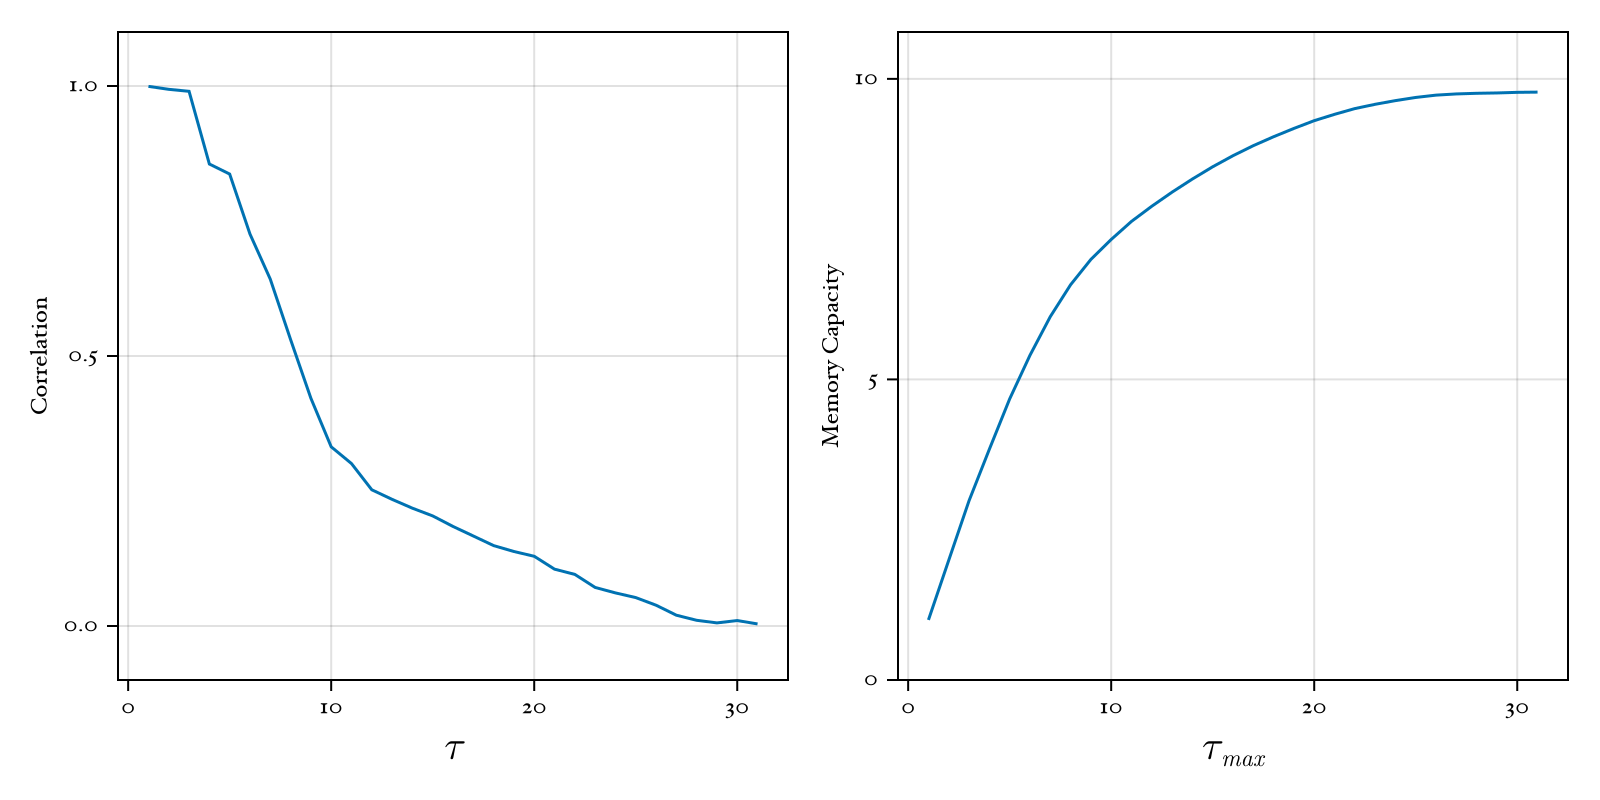

In [183]:
# plot_one_step_test(ESN_params)
mem_cap_fig = plot_memory_capacity(ESN_params, 30, 10000)

In [184]:
save("memory_capacity.pdf", mem_cap_fig)

CairoMakie.Screen{PDF}


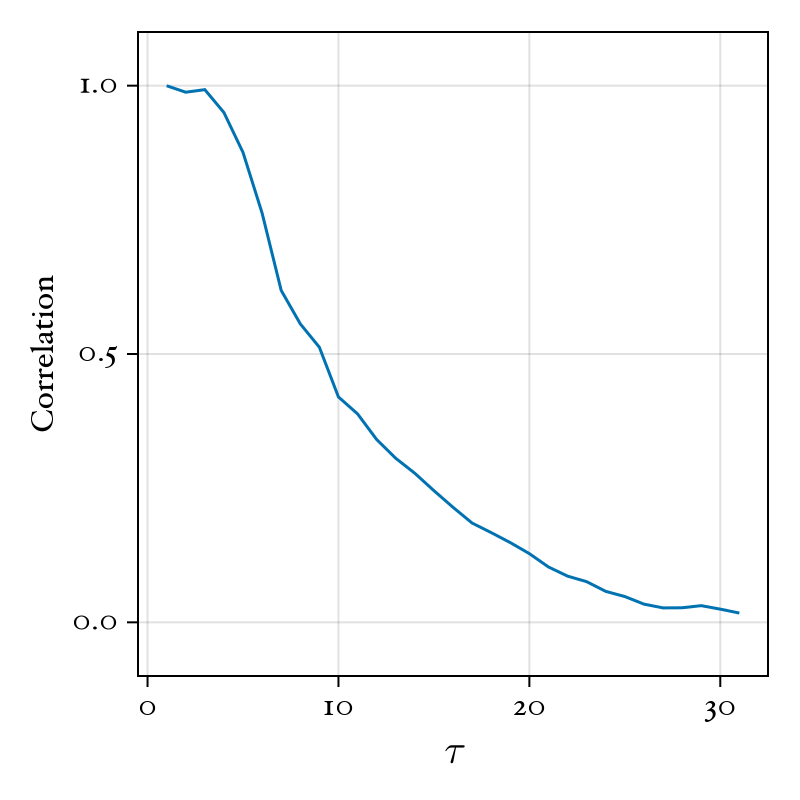

In [193]:
corr_coeffs = calculate_corr_coeffs(ESN_params, 30, 10000)
MCs = cumsum(corr_coeffs)

fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)
lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
ylims!(-0.1,1.1)

save("correlation.pdf", fig)

fig

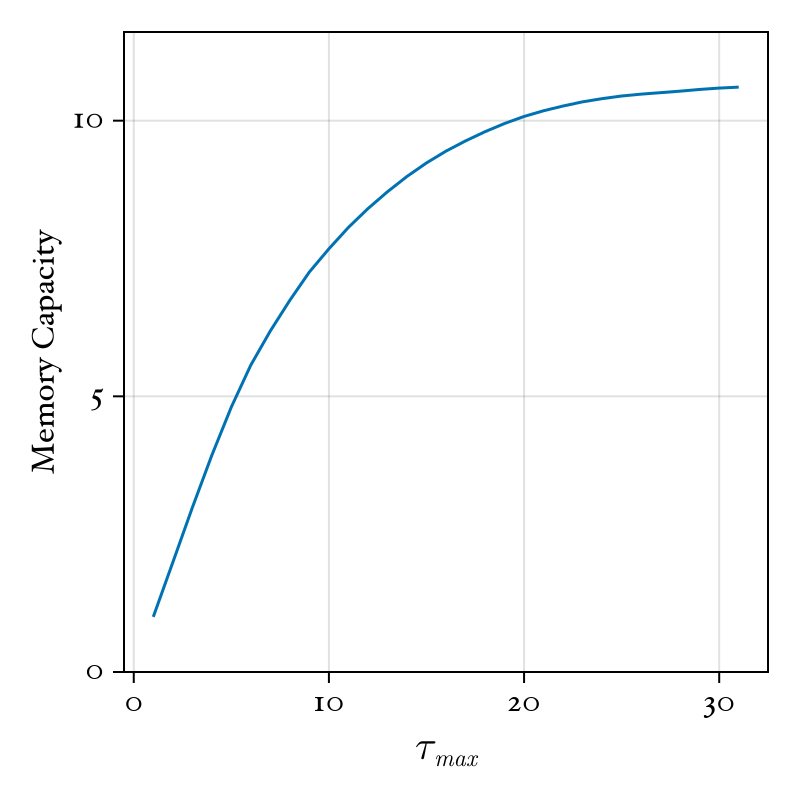

In [194]:
fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)

lines!(Axis(fig[1,1], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
ylims!(0,maximum(MCs)+1)

save("memory_capacity.pdf", fig)

fig

## Spectral radius vs error (correlation)

In [86]:
rho_test_range = 0:0.01:5.0
rho_test_errs = [one_step_errors(create_ESN_params(k, d, ρ_i, α, η, β)) for ρ_i in rho_test_range]

501-element Vector{Float64}:
  0.963029185281086
  0.9940358706277763
  0.9971807805508321
  0.9889645214307109
  0.9992545573917585
  0.9934733205035953
  0.9988149505688678
  0.9963497137316711
  0.9986116973425454
  0.9864756522151915
  0.999001434224408
  0.9995898616331853
  0.9828401676480653
  ⋮
  0.05599333898553609
  0.13119298406355168
 -0.05802961558369372
 -0.27949197739163995
  0.41419390166962294
 -0.6304975044425257
  0.1906276713178562
  0.32159610710120834
 -0.47133675449054835
 -0.09102220793149521
 -0.22268531056175703
  0.6892426762489648

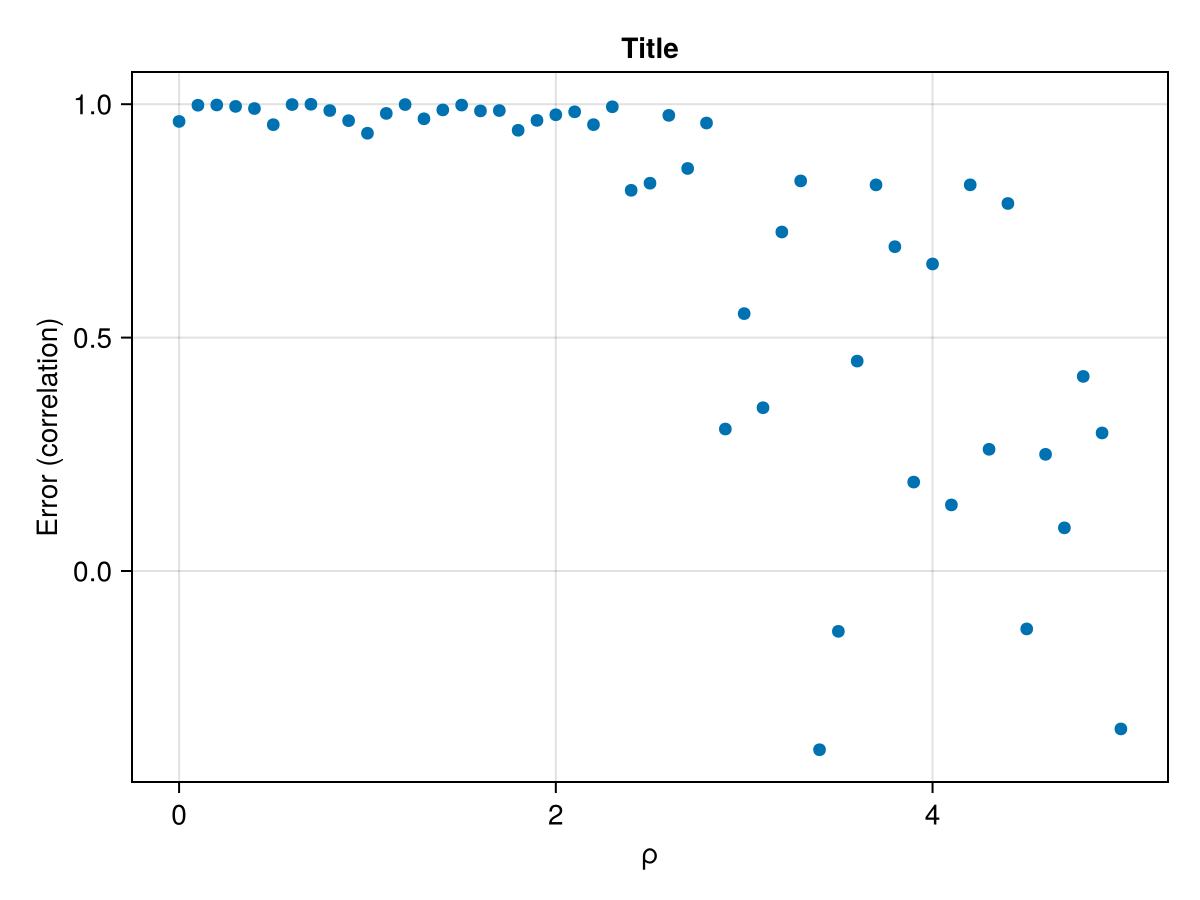

In [82]:
# plot(collect(rho_test_range),
#     rho_test_errs)
f = Figure()

ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Error (correlation)",
    title = "Title")
scatter!(collect(rho_test_range), rho_test_errs)

f

When the spectral radius is low, the correlation of the predicted to the actual trajectory appears to be high (approximately 1). As the spectral radius increases, the correlation drops and becomes more distributed randomly between -1 and 1. The correlation begins to drop between ρ=1 and ρ=2 and appears randomly distributed above around ρ=2.5.

## Spectral radius vs memory capacity

In [88]:
rho_test_mems = [find_max_delay(create_ESN_params(k, d, ρ_i, α, η, β), 30, 10000)
        for ρ_i in rho_test_range]

501-element Vector{Int64}:
 2
 3
 4
 4
 5
 4
 4
 4
 5
 5
 5
 6
 5
 ⋮
 3
 6
 3
 5
 1
 4
 5
 6
 4
 3
 3
 4

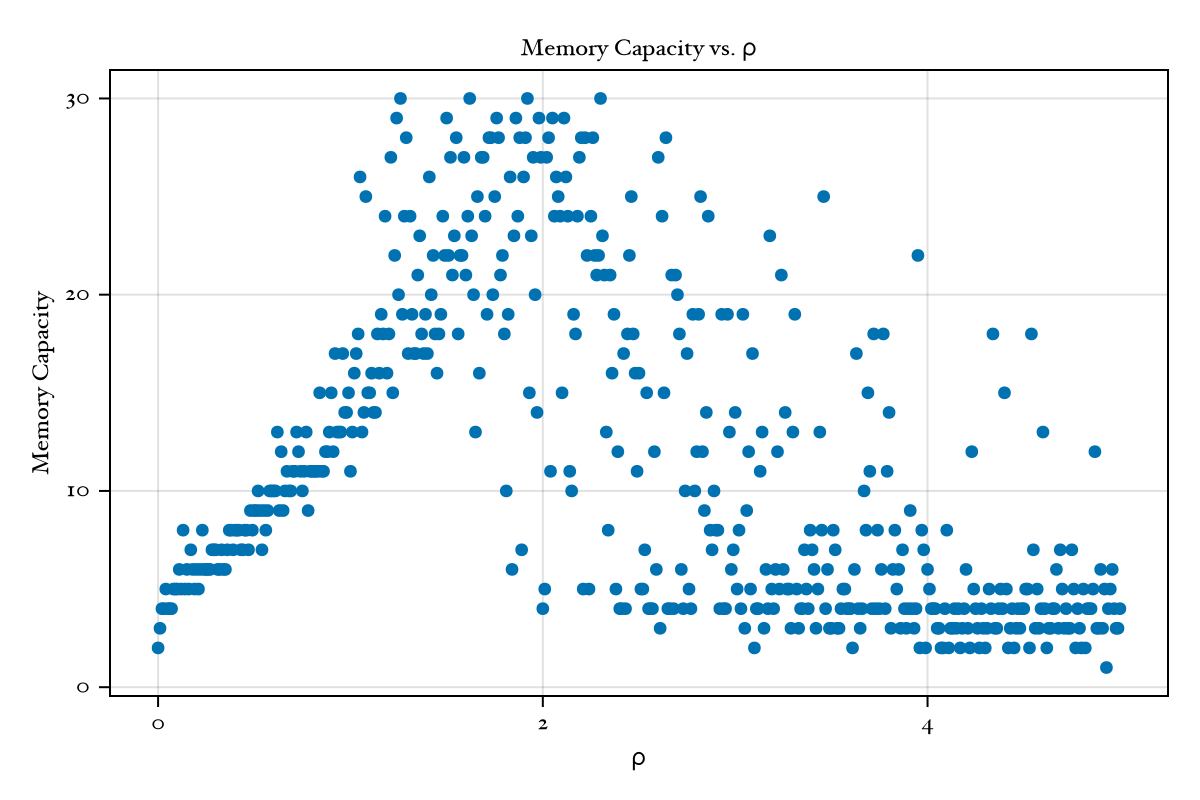

In [110]:
f = Figure(size = (600, 400), fontsize = 12, fonts = (; regular = "Tex", weird = "Blackchancery"))

ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Memory Capacity",
    title = "Memory Capacity vs. ρ", titlefont=:regular)
scatter!(collect(rho_test_range), rho_test_mems)
# set_theme!(font="Computer Modern")

f

In [113]:
save("memory capacity vs rho.pdf", f)#, pdf_version="1.4")

CairoMakie.Screen{PDF}


In [67]:
ρ = 1.0
k_test_range = [10,20,40,80,160]#50,100,200]#,500,1000]

for k_i in k_test_range
    println(k_i)
#     
    K_test_mem = find_max_delay(create_ESN_params(k_i, k_i*0.05, ρ, α, η, β), 30, 100000)
    
    println(K_test_mem)
end

10
Average train time: 1.8545286333333333
Average test time: 0.4977772333333333
MSE: 0.873716192077268
14
20
Average train time: 3.800851766666667
Average test time: 0.6388741000000002
MSE: 0.8513857497832343
22
40
Average train time: 5.576031399999999
Average test time: 0.9581802333333332
MSE: 0.8194760985206341
18
80
Average train time: 13.196529833333331
Average test time: 1.8210413999999995
MSE: 0.8002700112981905
17
160
Average train time: 95.04747940000001
Average test time: 5.317480933333333
MSE: 0.8067534268543317
15


As the spectral radius increases, the memory capacity generally increases up to around ρ=1.5 to ρ=2, afterwhich it decreases and plateaus around 1 to 6. After around ρ=1, the memory capacity becomes more variable, increasing from range of approximately 3-4 to a range of approximately 15.

## Freerun prediction

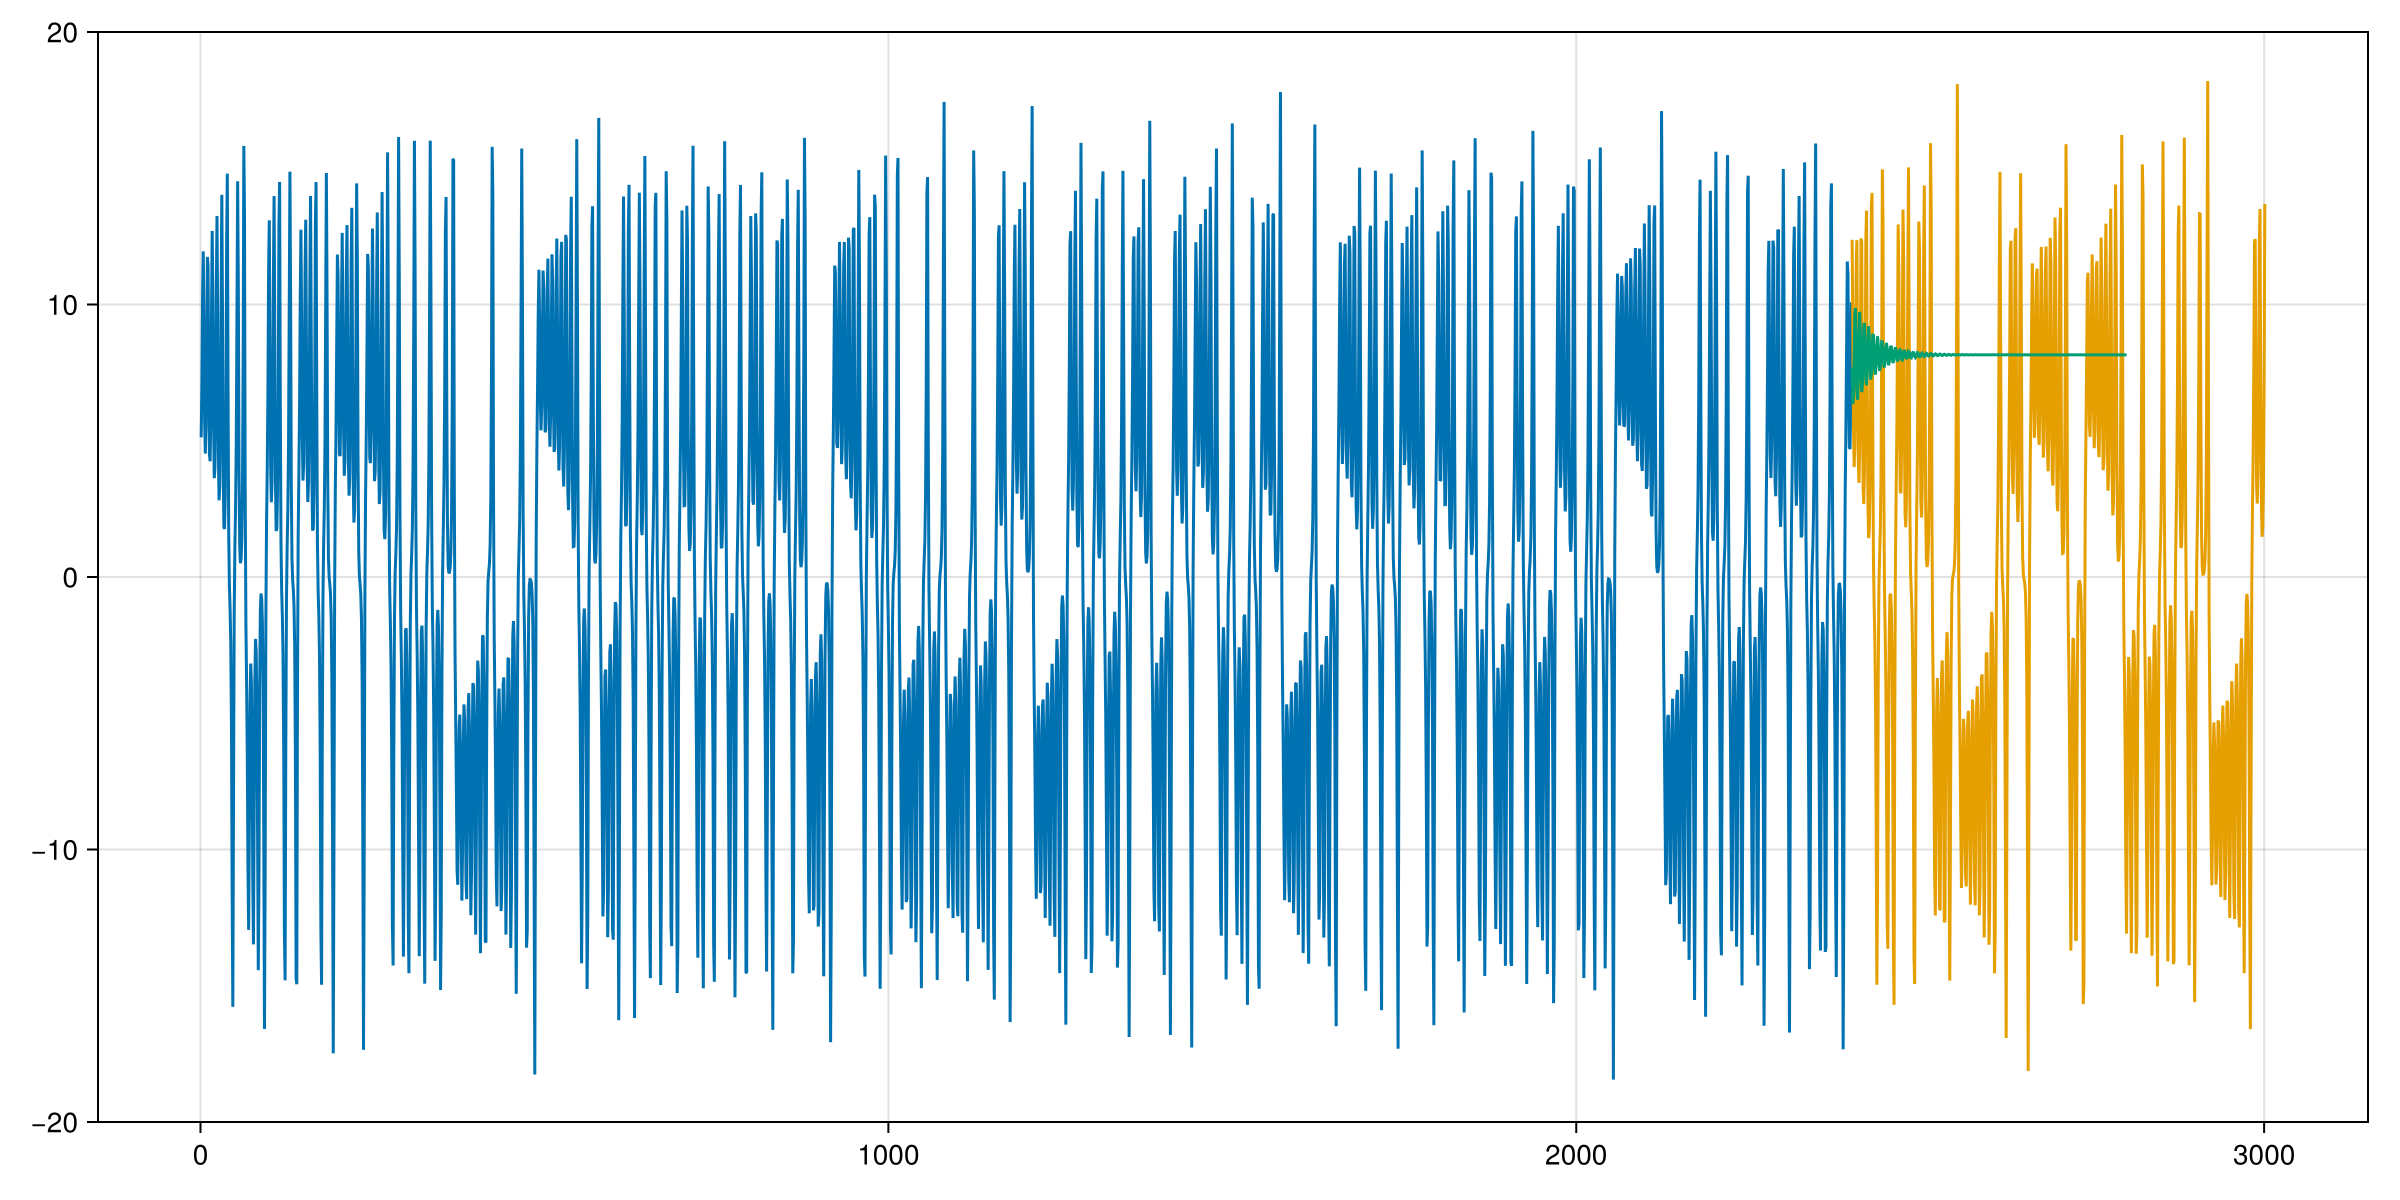

In [23]:
k = 50
d = k*0.05
ρ = 1.1
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)
R, train_states = train_one_step_pred(lo_train, ESN_params)


num_pred_steps = 400

current_state = train_states[end, :]
pred = [lo_train[end]]

preds = zeros(num_pred_steps)

for i in 1:num_pred_steps
    pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)

    current_state = current_state'
    preds[i] = pred[1]
end


fig = Figure( size = (1200,600) )
ax = Axis(fig[1,1])
lines!(ax, lo_train)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(lo_test)-1, lo_test)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(preds)-1, preds)
# xlims!(600,1000)
ylims!(-20,20)
fig

In [19]:
function train_one_step_pred(x, ESN_params; states=nothing)
    if states != nothing
        states = run_ESN(x, ESN_params)
    end
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

# Ordinal Readout Switching

In [20]:
function create_ordinal_partition(tr, m, w, τ; unique_partitions = nothing)
    rankings = zeros(Int, trunc(Int, length(tr)/w - τ*(m-1)), m)
    for j in 1:1:trunc(Int, length(tr)/w - τ*(m-1))
        x = w*(j-1) + 1
        rankings[j, :] = sortperm([tr[i] for i in x:τ:(x+τ*(m-1))])
    end
    if unique_partitions == nothing
        unique_partitions = unique(eachrow(rankings))
    end
    part_symbols = [findfirst(==(row), unique_partitions) for row in eachrow(rankings)]
    return(part_symbols, unique_partitions)
end

function find_probs(partition)
    df = DataFrame(partition, :auto)
    counts = combine(groupby(df, names(df)), nrow => :count)
    counts.probability = counts.count ./ sum(counts.count)
    return(counts)
end

find_probs (generic function with 1 method)

In [27]:
function train_one_step_pred_with_mask(x, ESN_params, mask; states = nothing)
    if states == nothing
        states = run_ESN(x, ESN_params)
    end
    
    target_z = x[[false; mask[1:end-1]]]
    predicted_states = states[1:size(states)[1]-1,:][mask[1:end-1],:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = nothing)
    num_symbols = length(unique_partitions)
    Rs = Matrix(undef, num_symbols, ESN_params.k)

    for i in 1:num_symbols
        part_mask = [part_symbols .== i; fill(false, window_size)]
        R, train_states = train_one_step_pred_with_mask(lo_train, ESN_params, part_mask; states=states)
        Rs[i, :] = R
    end
    
    return(Rs)
end

function one_step_pred_partitioned(x, ESN_params, Rs; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*Rs'
    
    return(preds, states)
end

one_step_pred_partitioned (generic function with 1 method)

In [22]:
function switch_prediction(y, prediction_series, unique_partitions, m, w, τ)
    part_symbols, _ = create_ordinal_partition(y, m, w, τ; unique_partitions = unique_partitions)
    switching_prediction = [prediction_series[i, part_symbols[i]] for i in 1:length(part_symbols)]
    
    return(switching_prediction)
end

switch_prediction (generic function with 1 method)

In [23]:
function create_transition_matrix(part_symbols)
    # Example array of symbols
    symbols = unique(part_symbols)

    # 2×n matrix of transitions
    transitions = [part_symbols[1:end-1] part_symbols[2:end]]

    # Initialize transition matrix
    n = length(symbols)
    transition_matrix = zeros(Float64, n, n)

    # Count transitions
    for row in 1:size(transitions, 1)
        i = findfirst(isequal(transitions[row, 1]), symbols)
        j = findfirst(isequal(transitions[row, 2]), symbols)
        transition_matrix[i, j] += 1
    end

    # Normalize rows to get transition probabilities
    for i in 1:n
        row_sum = sum(transition_matrix[i, :])
        if row_sum > 0
            transition_matrix[i, :] /= row_sum
        end
    end

    return(transition_matrix)
end

create_transition_matrix (generic function with 1 method)

In [29]:
k = 50
d = k*0.05
ρ = 1.05
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

states = run_ESN(lo_train, ESN_params)

# Train regular ol' ESN
R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

# Create ordinal partition
m = 3
w = 1
τ = 2
window_size = (m-1)*τ
part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

# Train partition based readout
Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states=states)
# Create transition matrix and modify the partition based readout
transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

6×50 Matrix{Any}:
  1.87125   1.76685   1.51891   18.3631   …   -6.30298  0.720977    3.55308
  7.99293   0.496474  0.876814  20.3255       -2.30655  0.672152    3.11152
  6.10742   0.690056  0.527091  20.7422       -5.19305  0.0773457   1.66151
 -1.20776   1.02064   1.43041   18.8193      -15.8298   0.00102283  1.3417
 -0.758417  1.04607   3.65897    9.39303     -13.7482   1.85673     8.55707
 -0.228143  1.54036   3.18484    8.63831  …   -8.74879  1.688       7.38464

In [30]:
preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
# switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])

([9.114683824133367, 5.444795066361095, 4.177741200124917, 5.14755672153454, 7.707006431369658, 11.443723094660177, 12.064689659191378, 7.452587769452775, 4.30700743371351, 3.66971398793393  …  12.028850494526752, 13.381812064989811, 7.001052374324974, 2.910814776442731, 1.611546529701089, 2.043285633659366, 3.5712952080404143, 6.914204944617358, 13.056162640701476, 14.028772506311858], [0.23591418481501802 -0.9903642304231959 … 0.9505941971355892 -0.9488173899137737; 0.31359905057074755 -0.9910397107496509 … 0.9497742852126309 -0.9278301024747881; … ; 0.4044750024778645 -0.9886037877241475 … 0.9490726094027617 -0.90139103592133; 0.20372638088260012 -0.9894415227192732 … 0.9509539885834821 -0.9560388203165756])

In [31]:
start_skip = 10

println(cor(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end]))
println(cor(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)]))
println(cor(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)]))

0.9983982588629344
0.9992197996048963
0.9966529503387164


0.9983980093297206


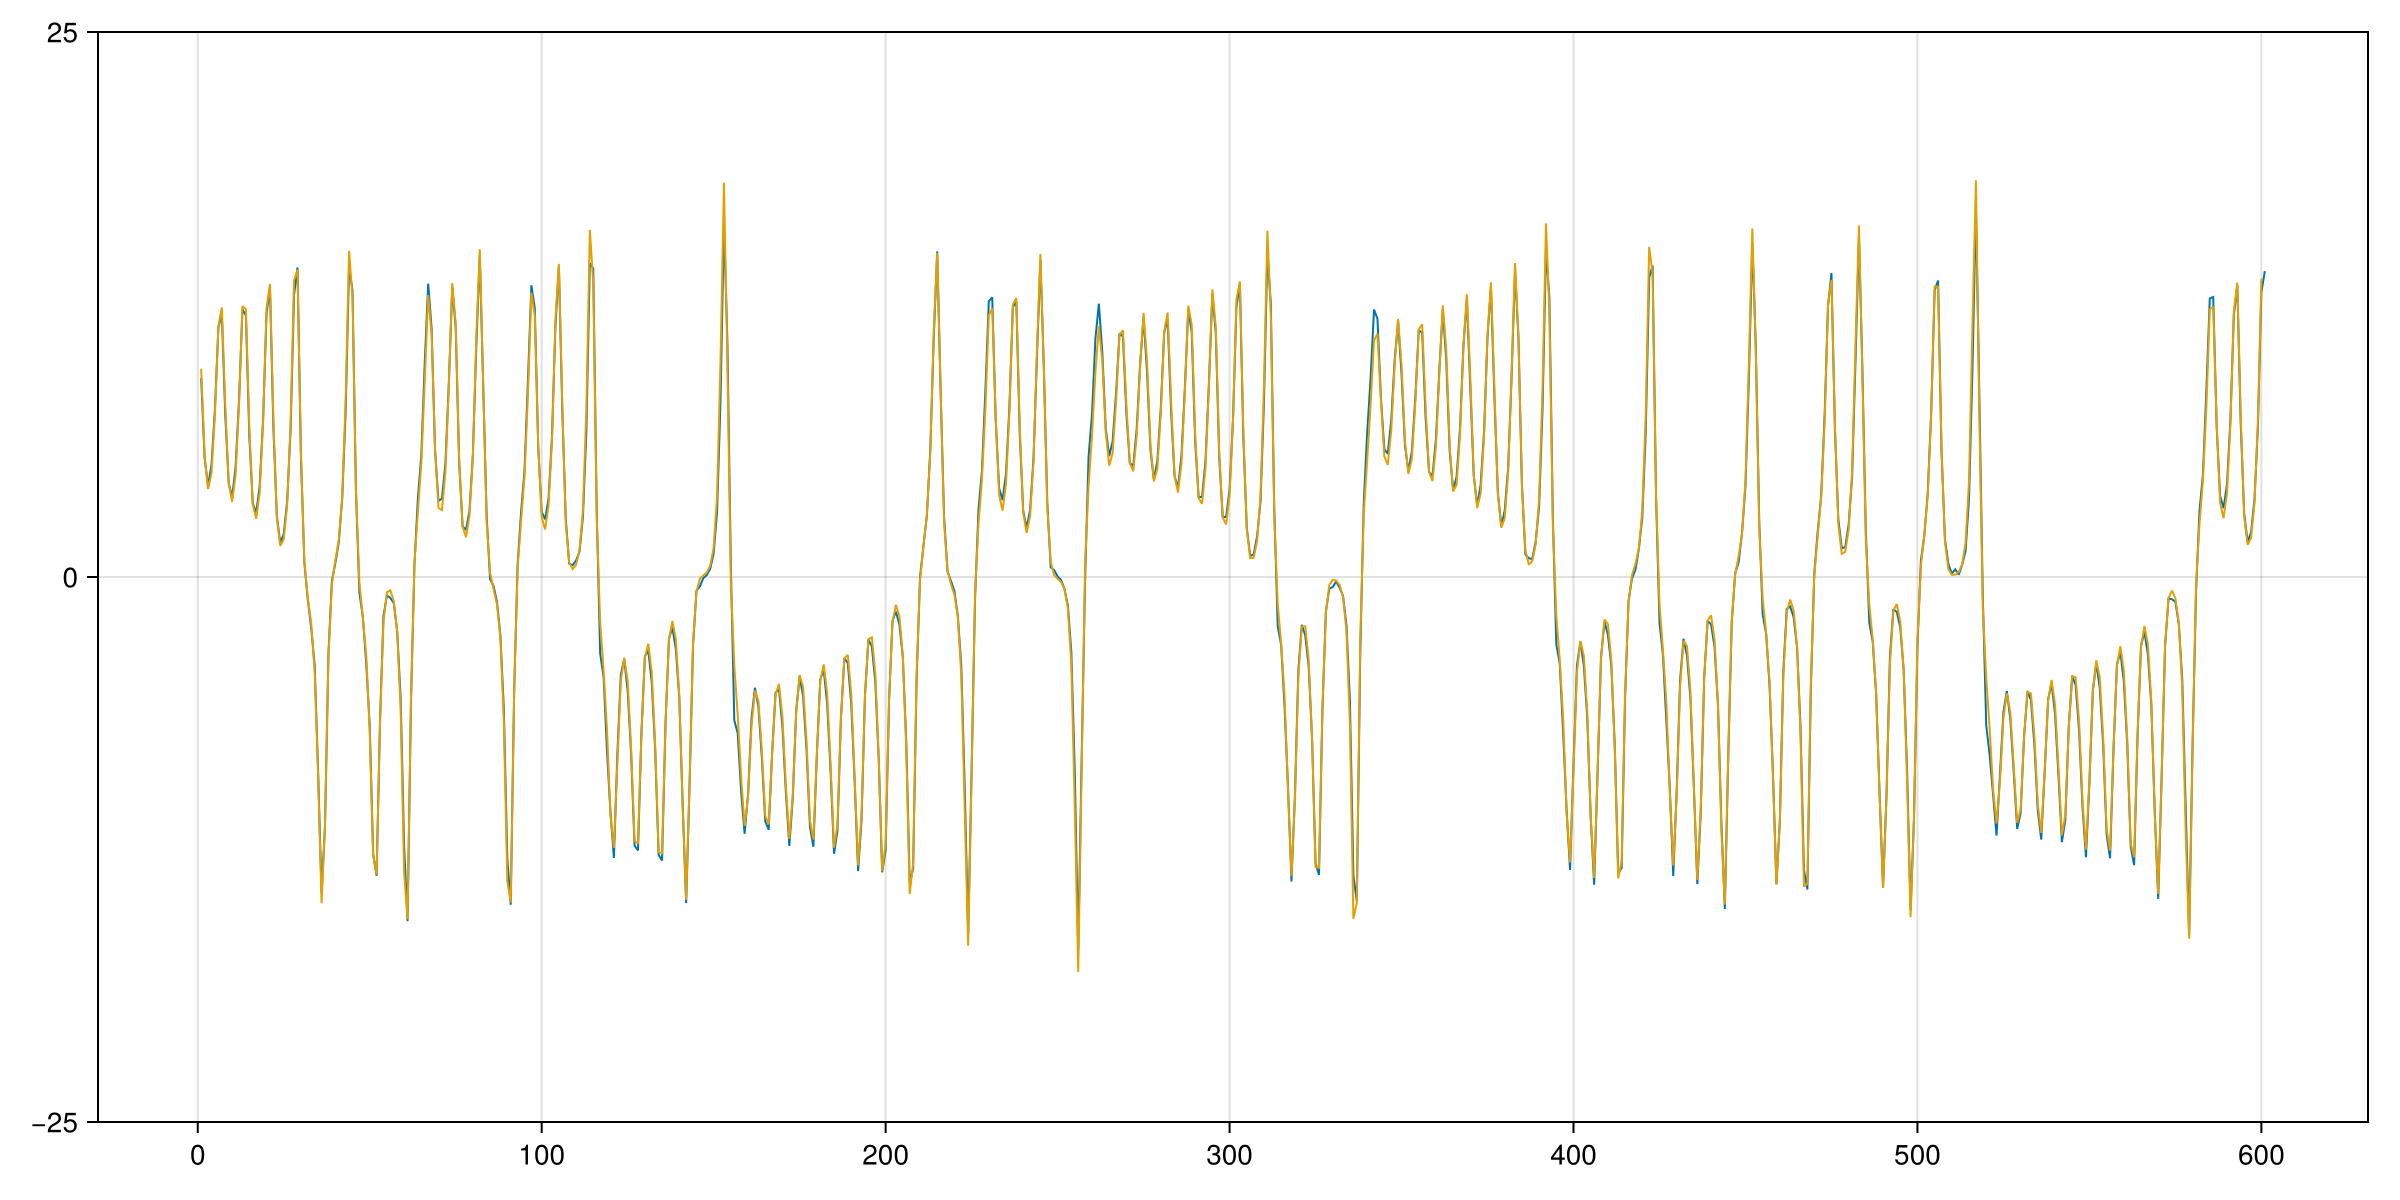

0.9992200642618169


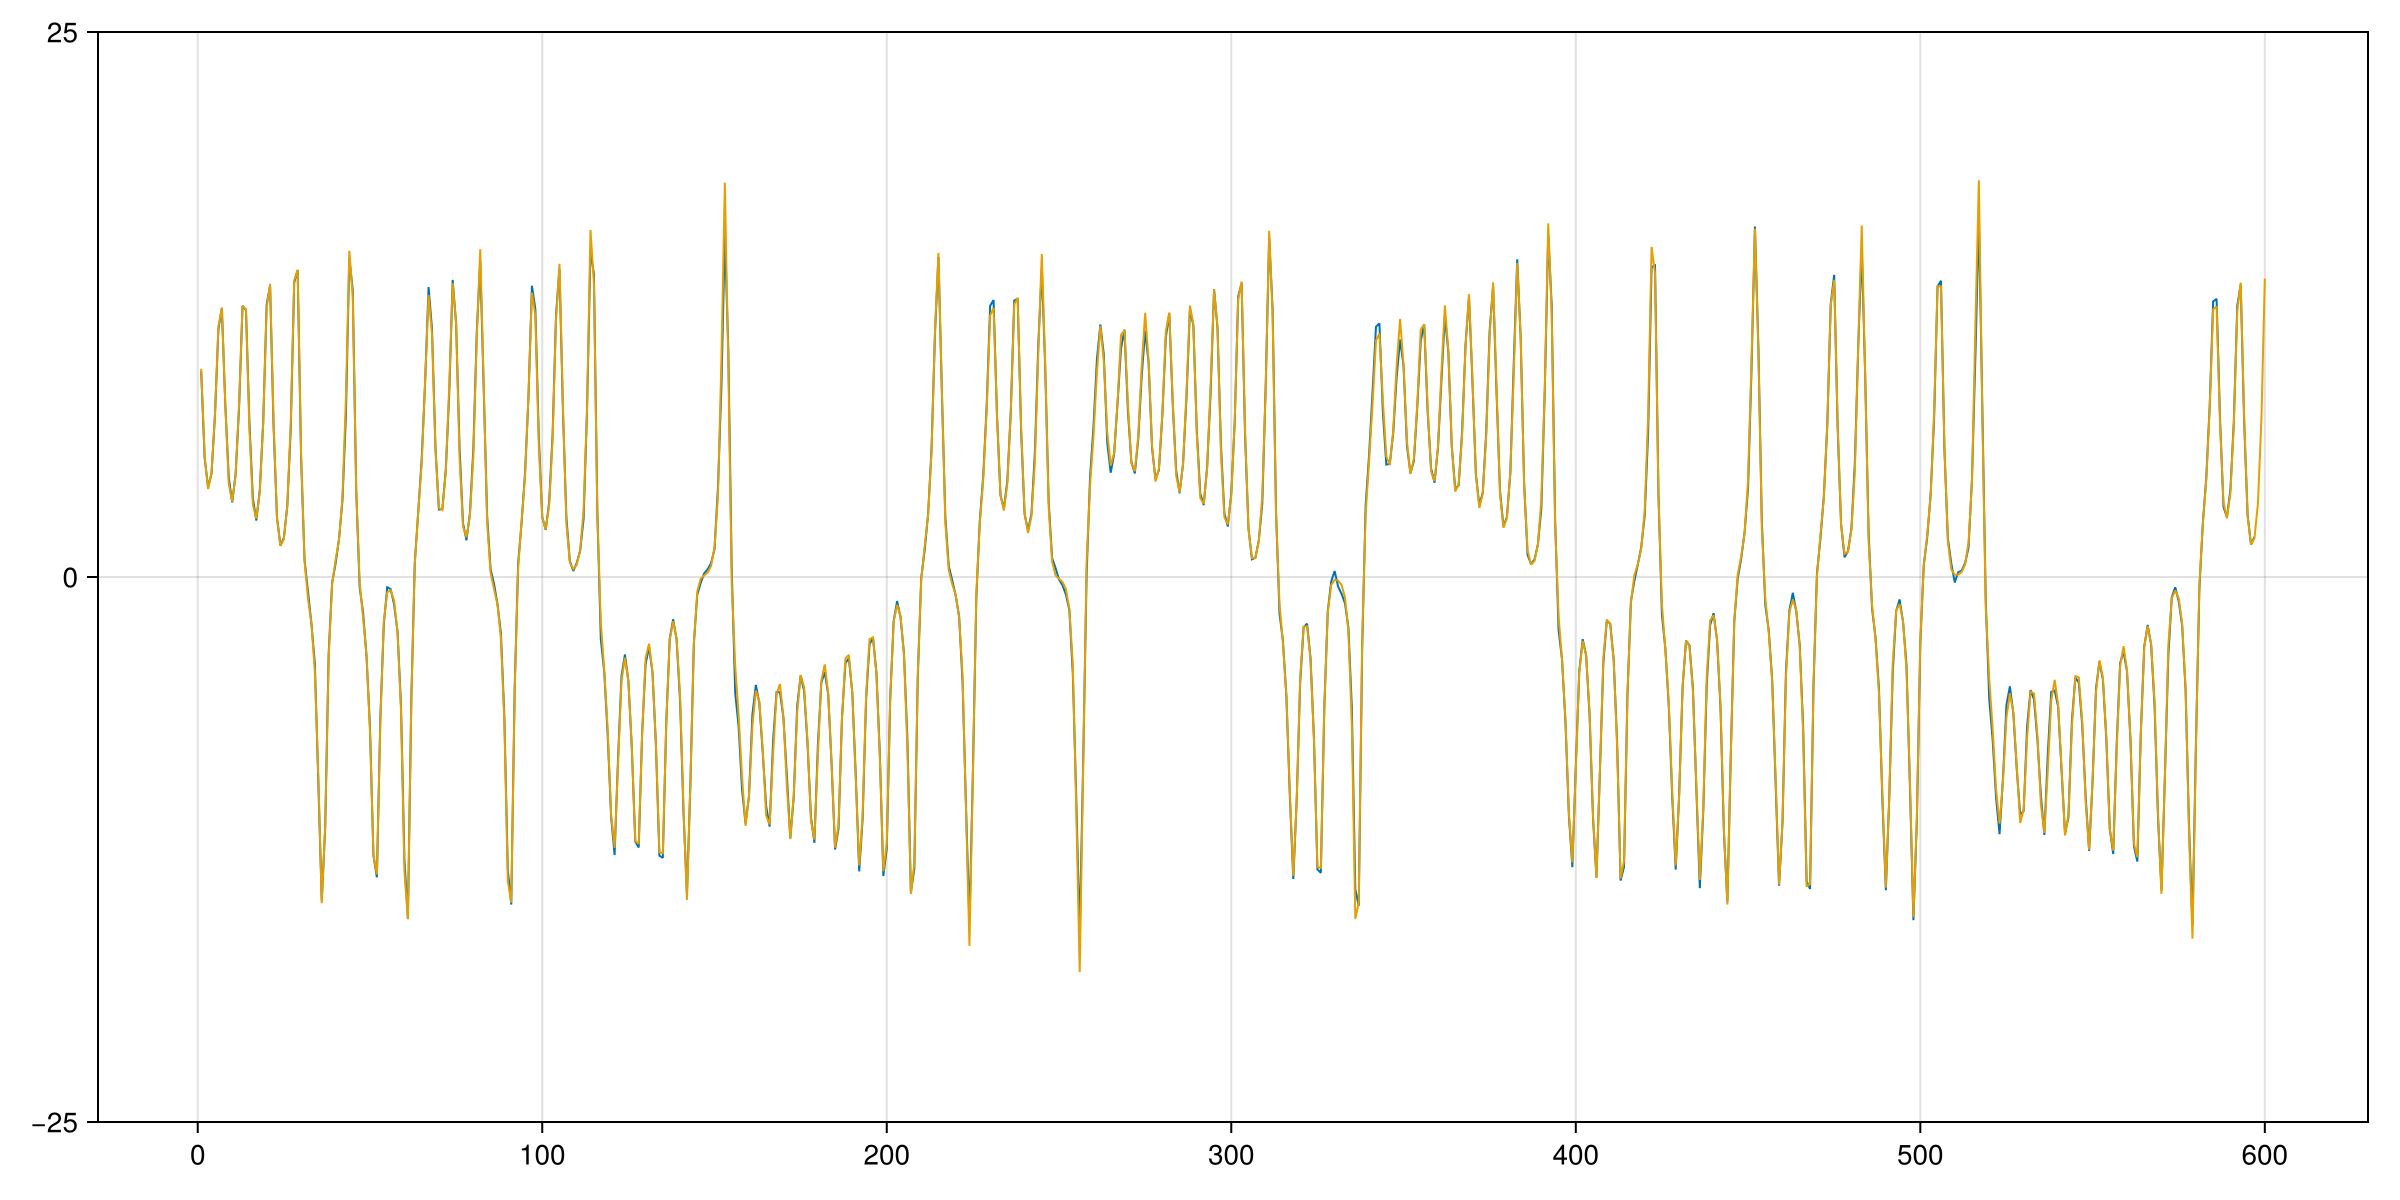

0.9966525465082642


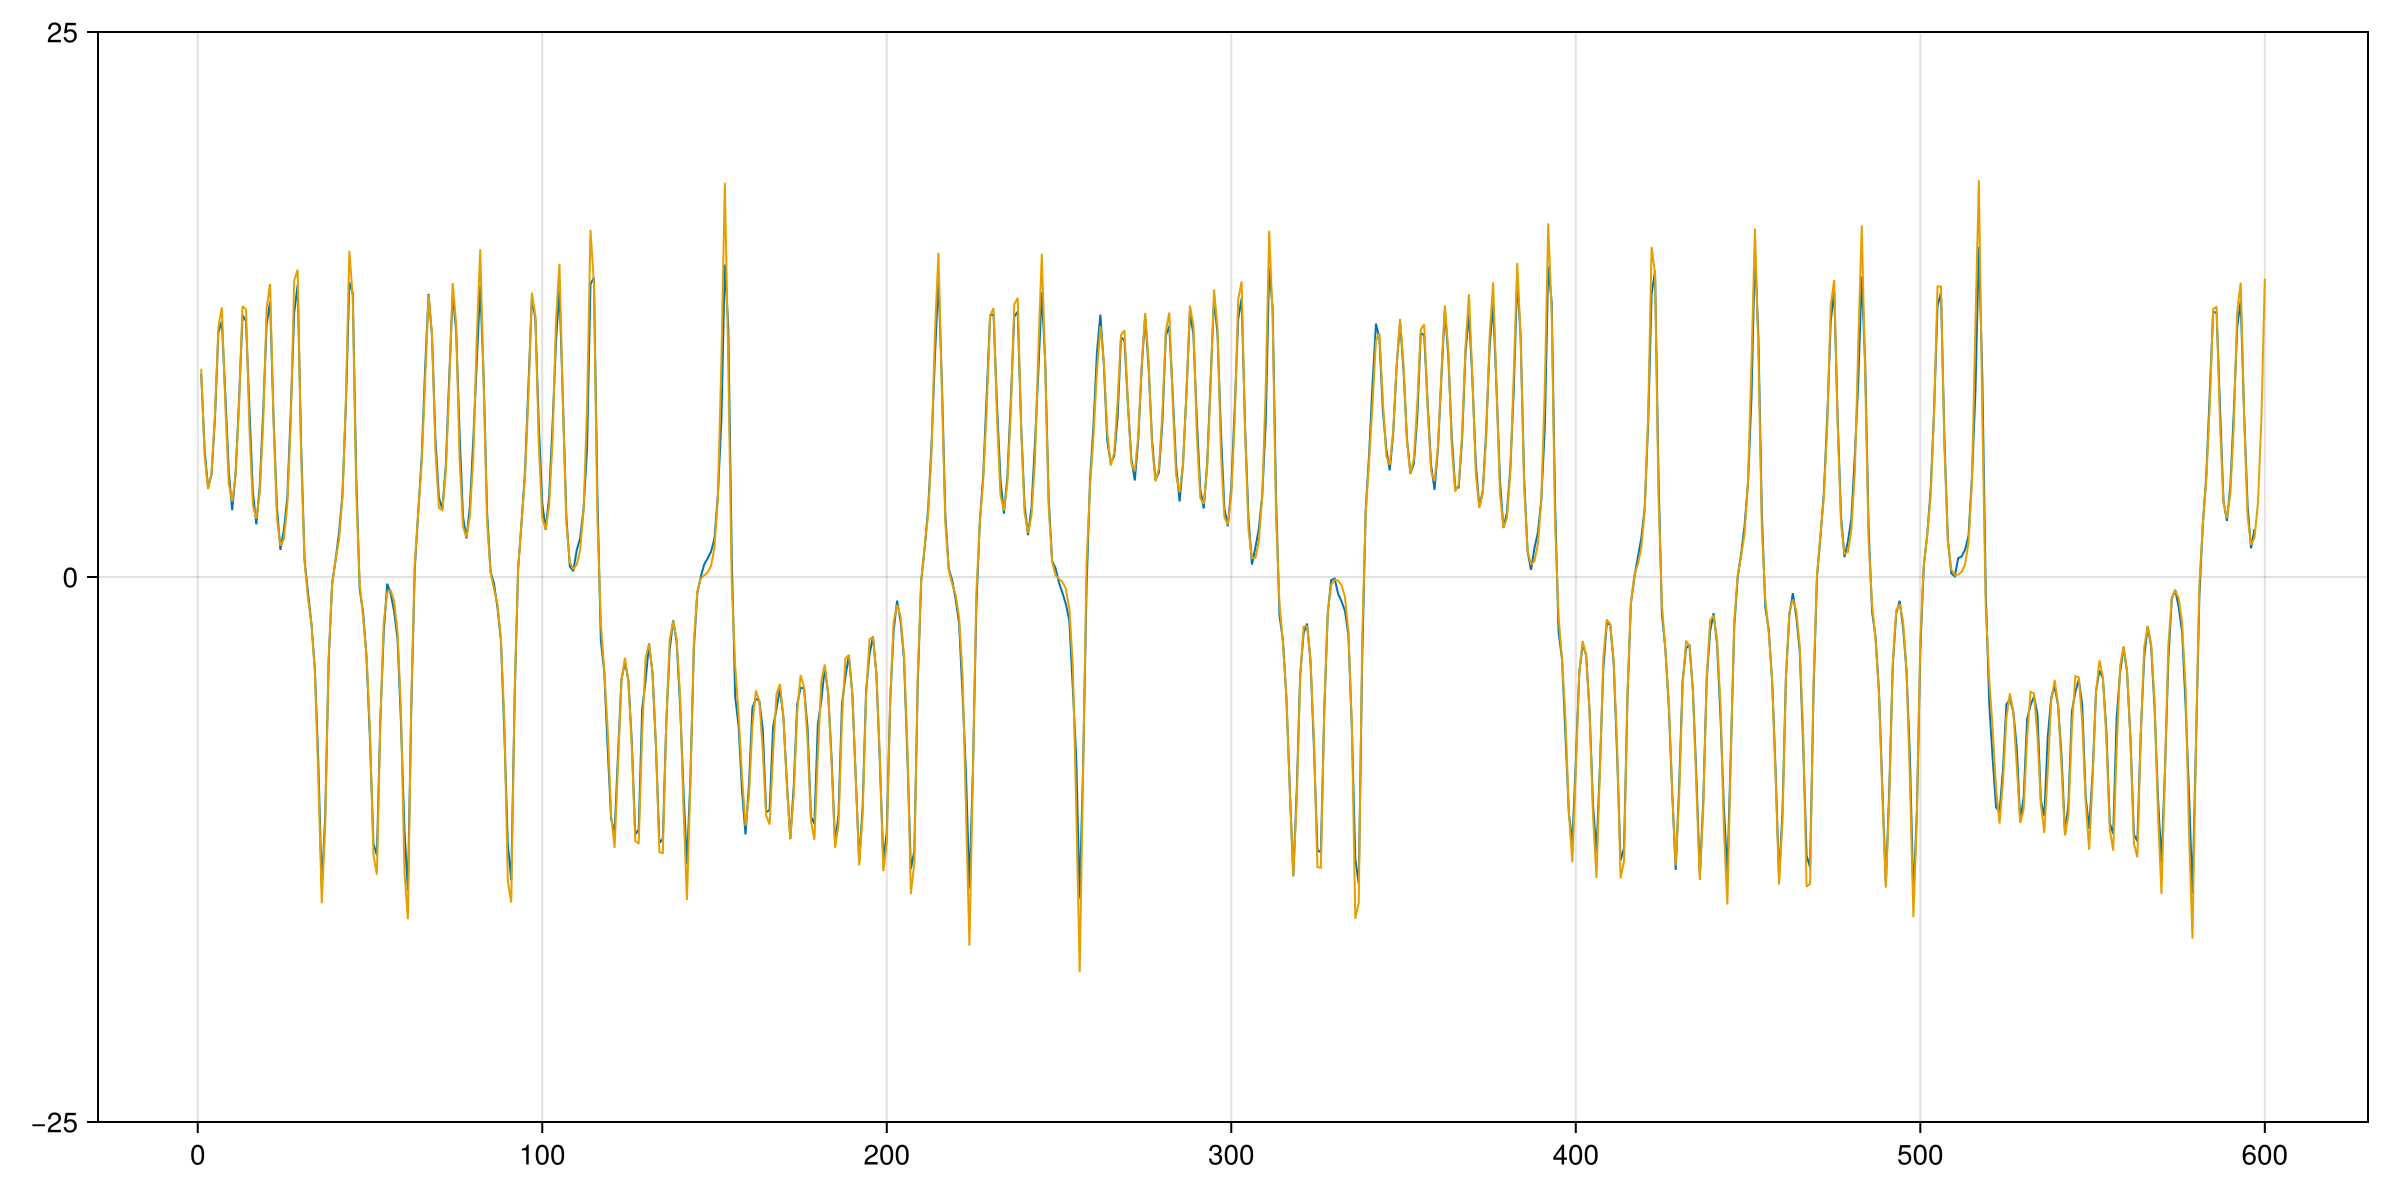

In [32]:
for preds in [vanilla_preds, switching_pred, ON_modified_switching_pred]
    println(cor(preds[1+9:end-1], lo_test[2+9:length(preds)]))
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    # xlims!(0,300)
    ylims!(-25,25)
    display(fig)
end

In [33]:
function freerun_prediction(R, current_state, ESN_params; switch=false, unique_partitions=nothing, window_size=nothing, m=nothing, w=nothing, τ=nothing)
    num_pred_steps = length(lo_test)
    
    if switch
        num_pred_steps = num_pred_steps - window_size
    end
    
    pred = [lo_train[end]]
    preds = zeros(num_pred_steps)

    for i in 1:num_pred_steps
        if switch
            all_preds, current_state = one_step_pred_partitioned(pred, ESN_params, R; S=current_state)
            pred = switch_prediction(lo_test[i:i+window_size], all_preds, unique_partitions, m, w, τ)
        else
            pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)
        end

        current_state = current_state'
        preds[i] = pred[1]
    end
    
    return(preds)
end

freerun_prediction (generic function with 1 method)

In [34]:
vanilla_freerun_preds = freerun_prediction(R, train_states[end, :], ESN_params)
switching_freerun_pred = freerun_prediction(Rs, train_states[end, :], ESN_params; switch=true, unique_partitions=unique_partitions, window_size=window_size, m=m, w=w, τ=τ)
ON_modified_switching_freerun_pred = freerun_prediction(transition_matrix_modified_Rs, train_states[end, :], ESN_params; switch=true, unique_partitions=unique_partitions, window_size=window_size, m=m, w=w, τ=τ)
;

0.04487686658028889


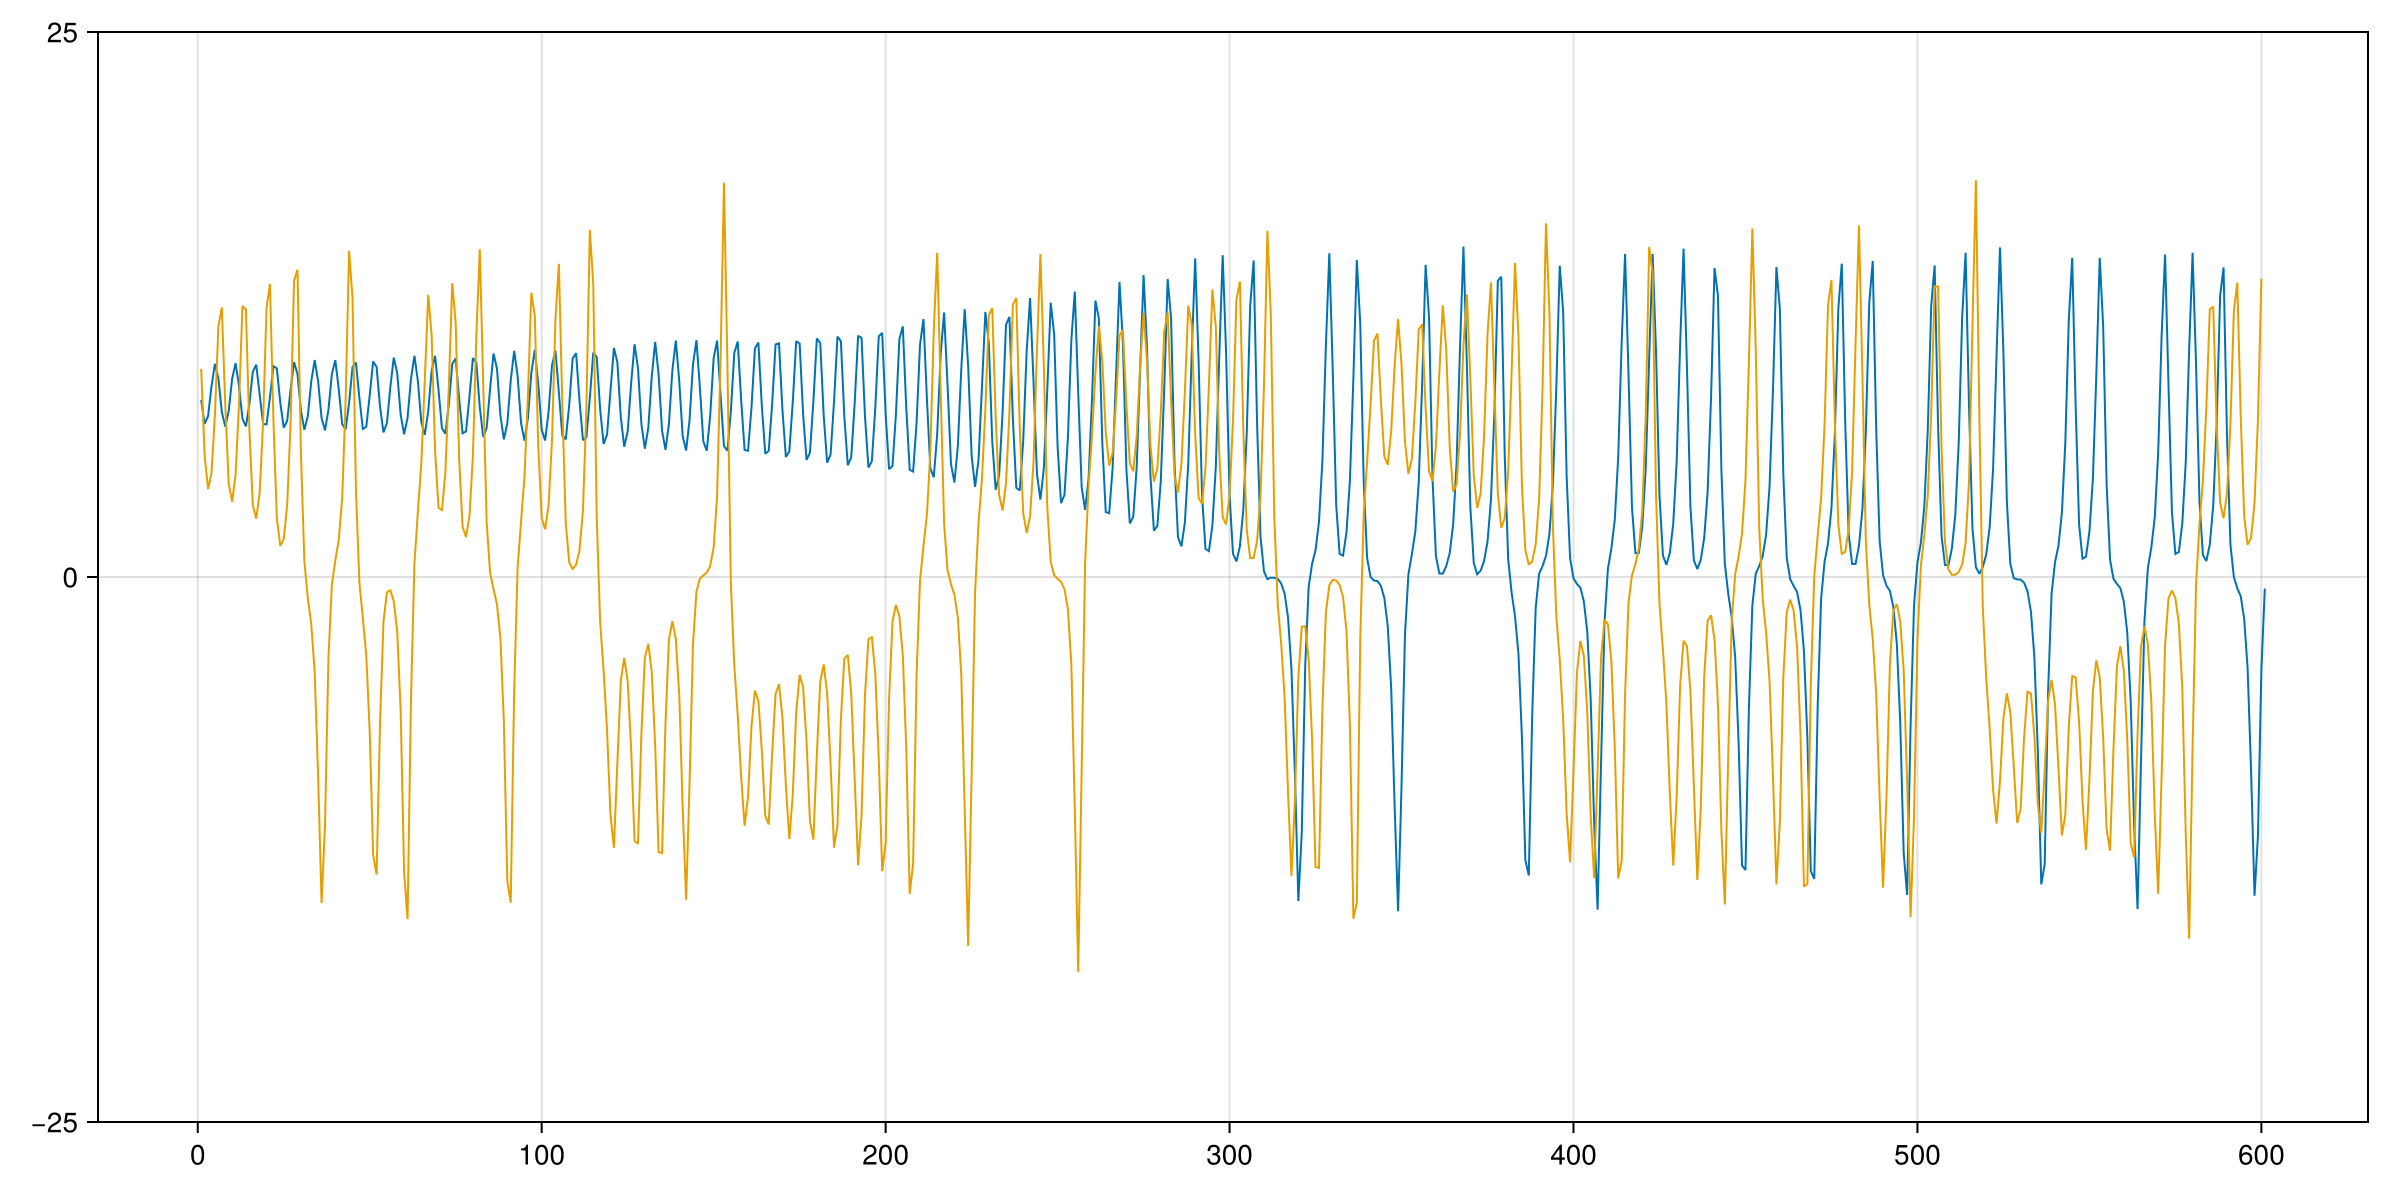

0.28079856463406605


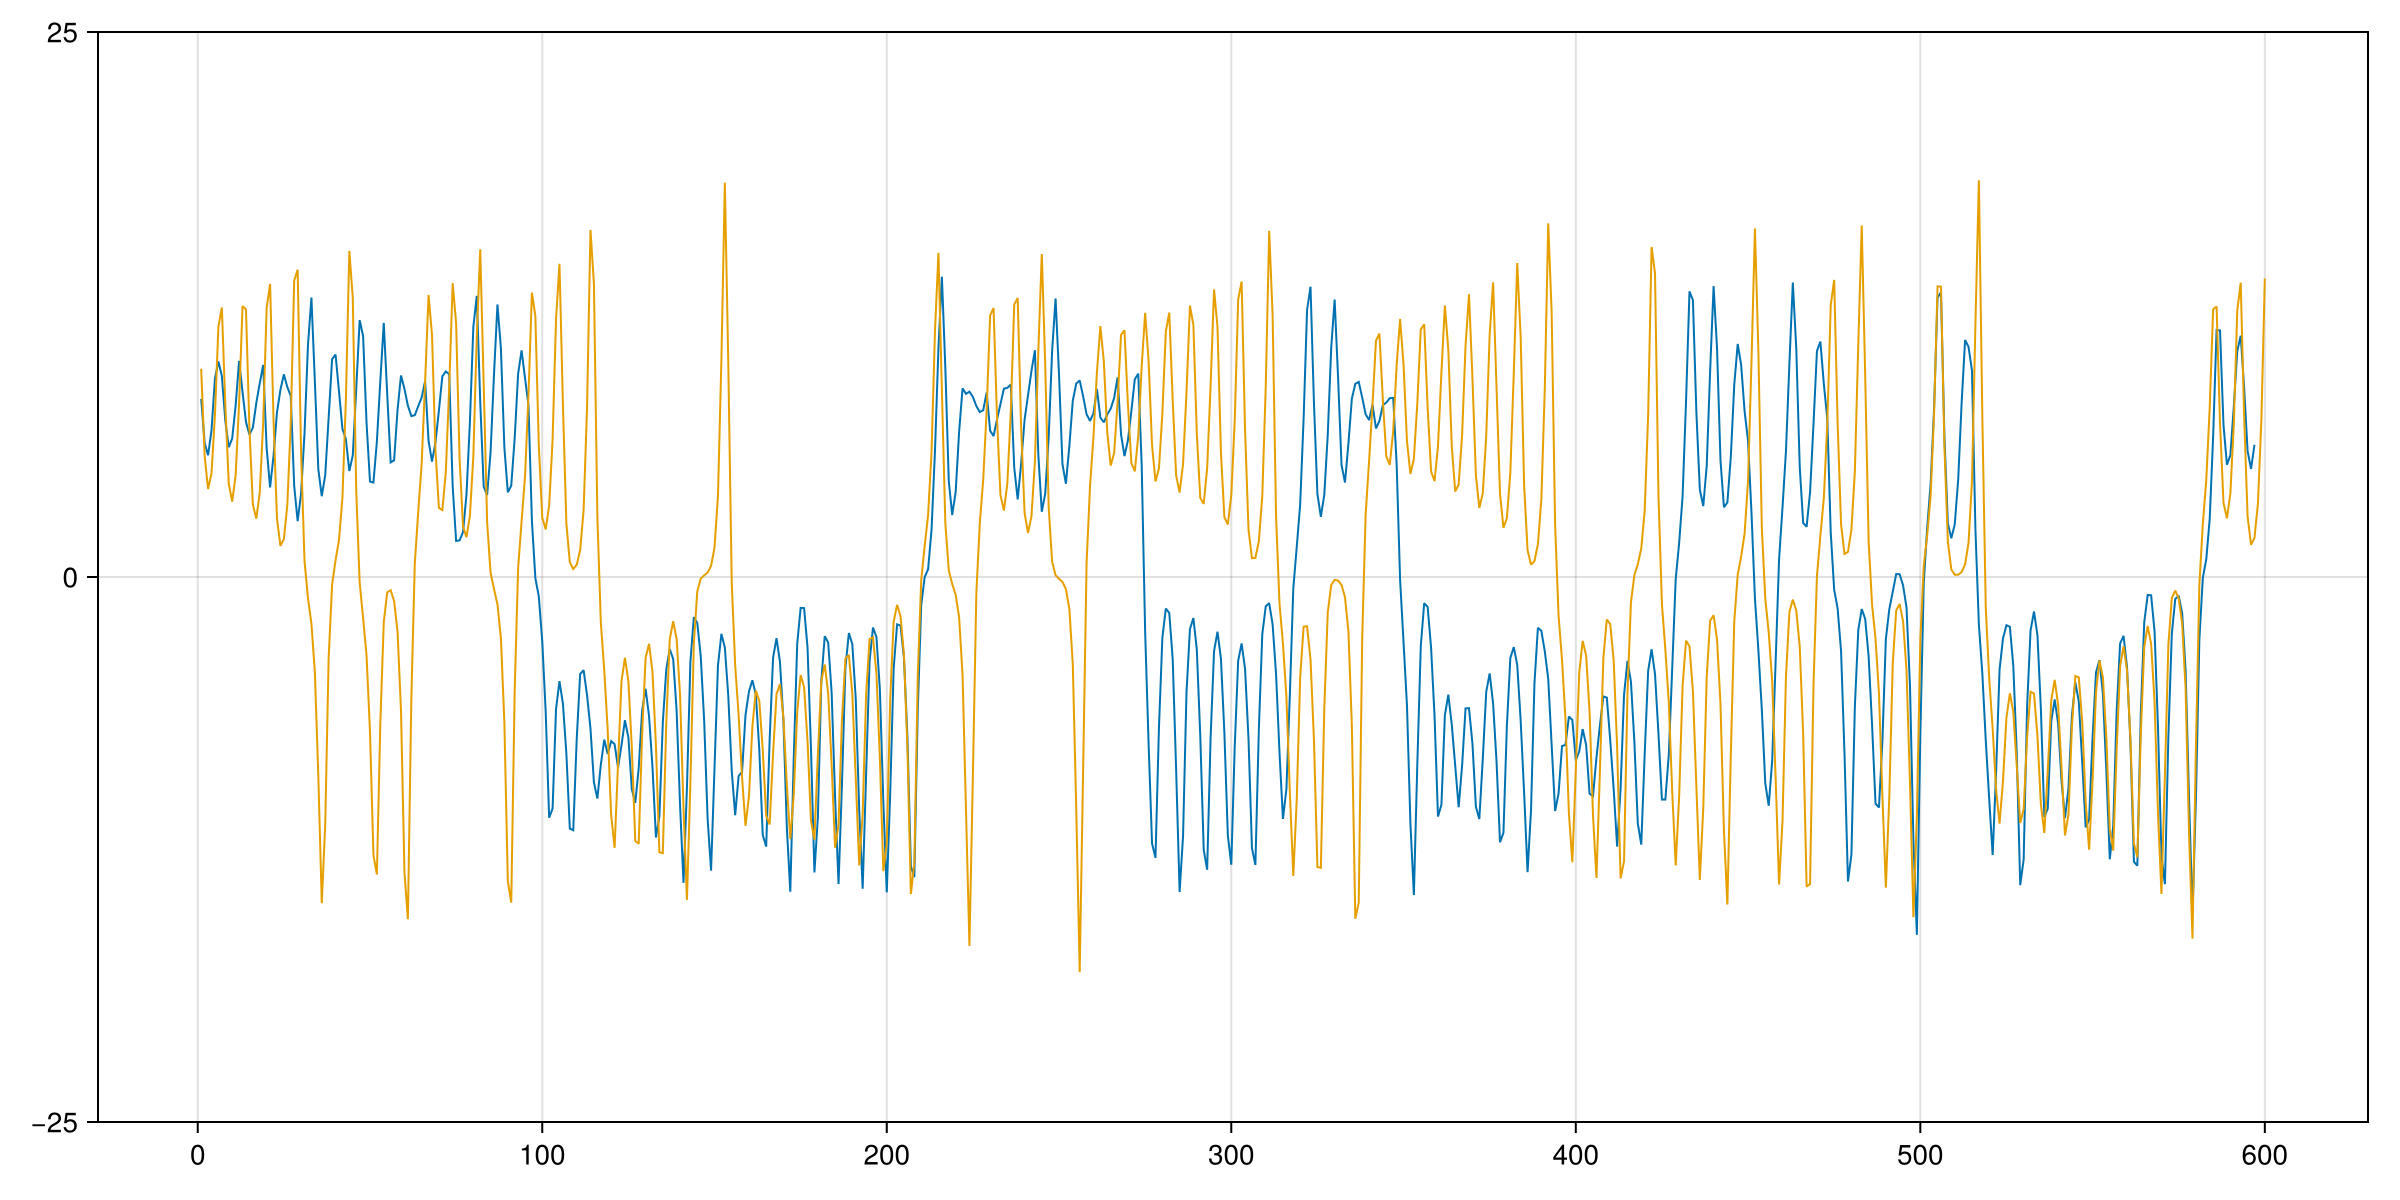

-0.024904717764848698


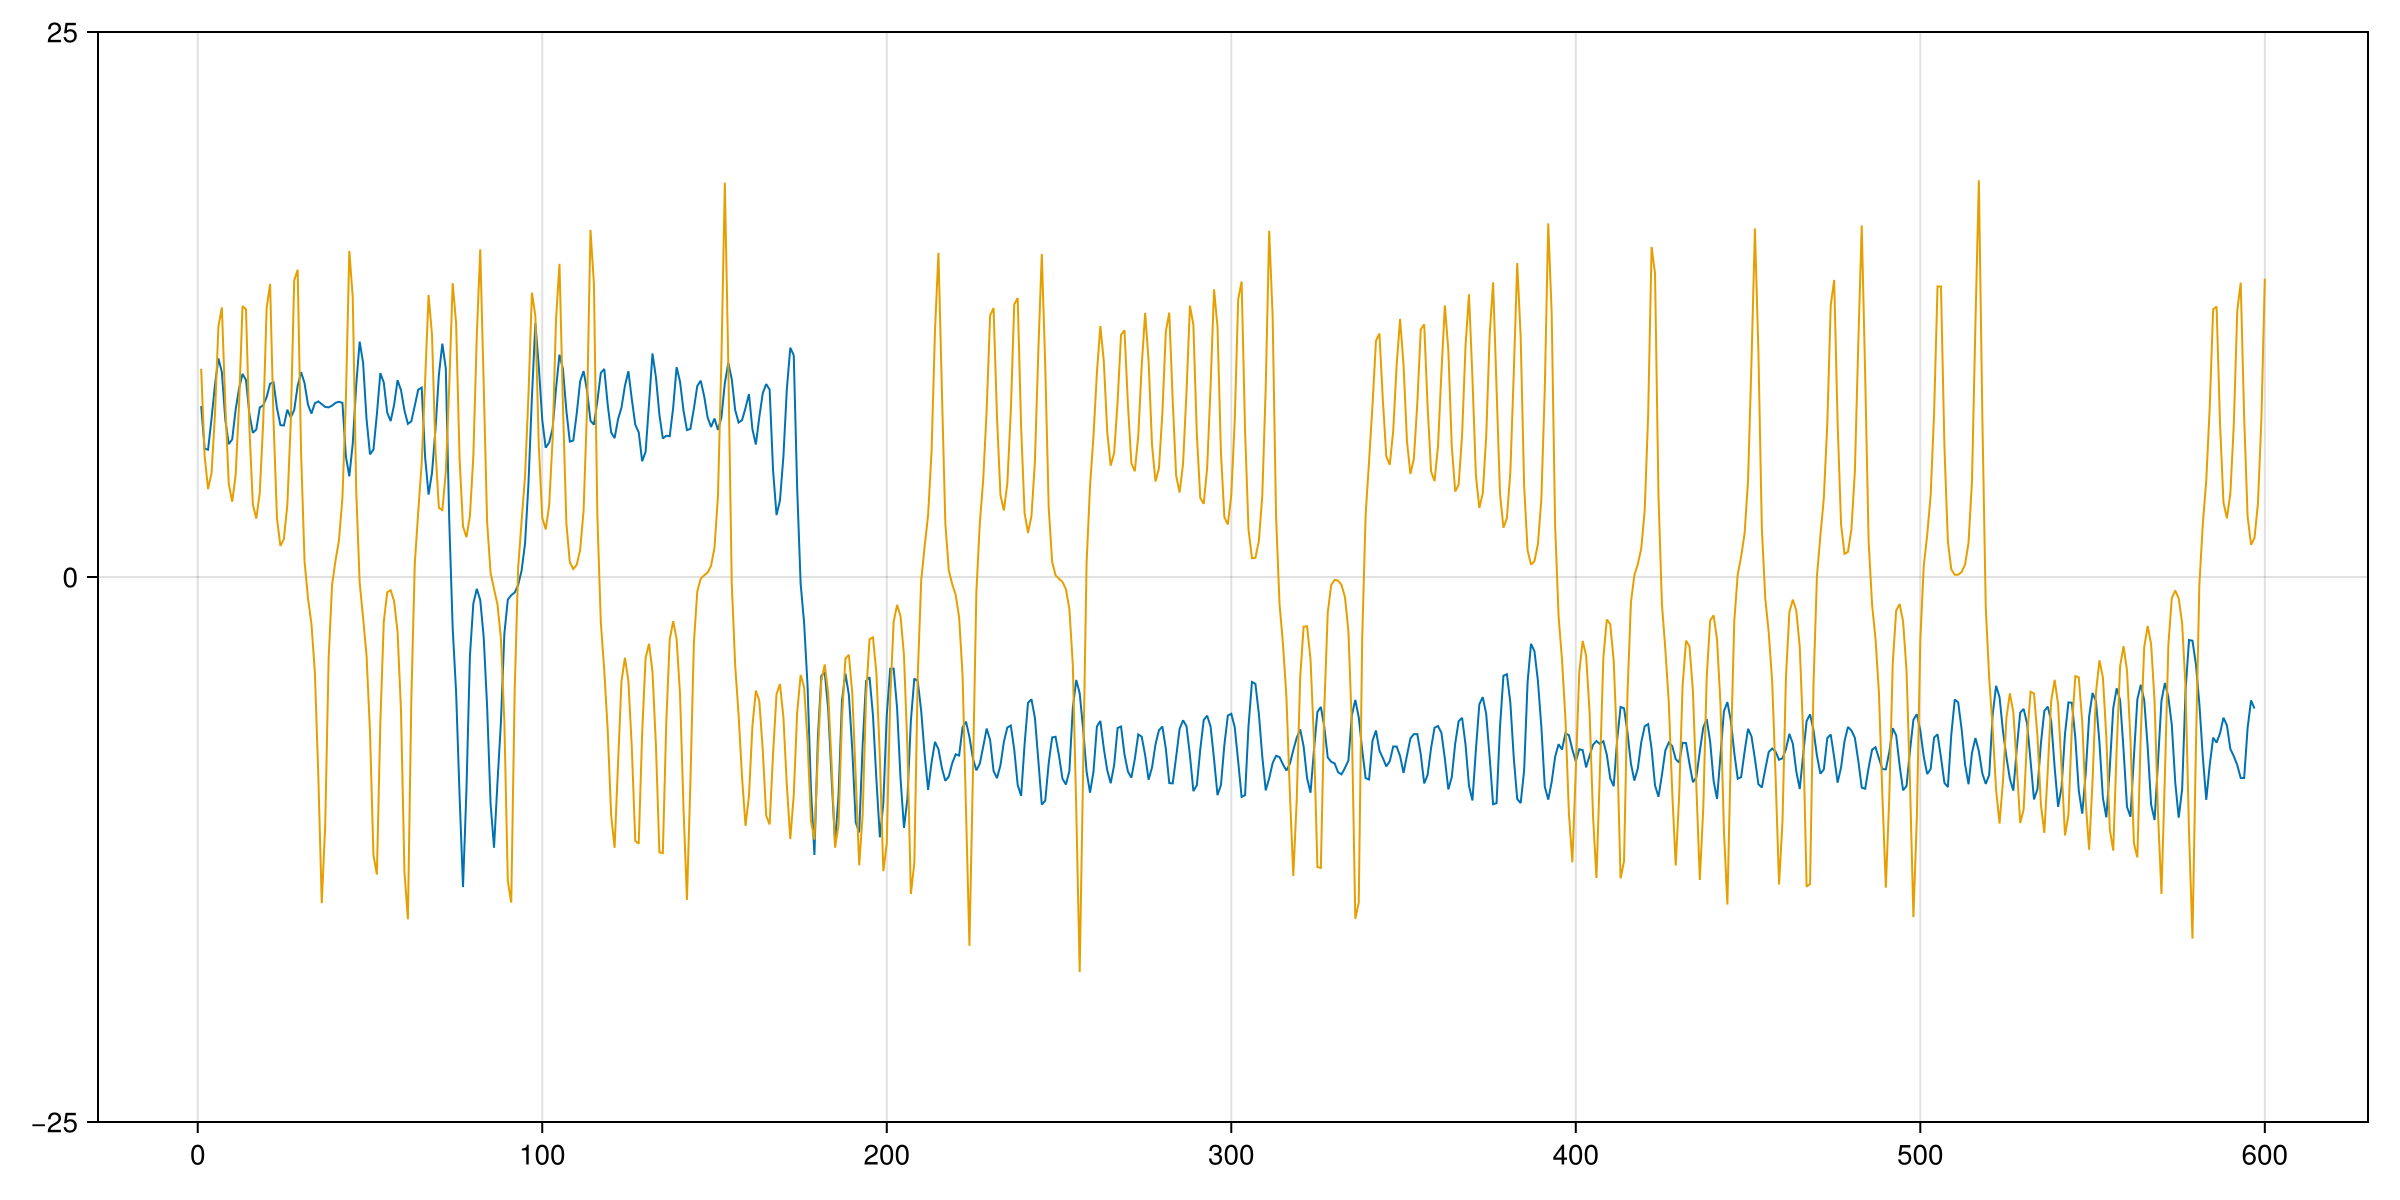

In [35]:
for preds in [vanilla_freerun_preds, switching_freerun_pred, ON_modified_switching_freerun_pred]
    println(cor(preds[1:end-1], lo_test[2:length(preds)]))
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    # xlims!(0,300)
    ylims!(-25,25)
    display(fig)
end

Seems to do better with fewer nodes. Has issue with turning points, see worse prediction around each turning point.

In [94]:
function trial_parameters(;
        k = 50,
        d = k*0.05,
        ρ = 1.05,
        α = 1.0,
        η = 1/maximum(lo_train),
        β = 0.01,
        m = 3,
        w = 1,
        τ = 1
    )
    ESN_params = create_ESN_params(k, d, ρ, α, η, β)

    states = run_ESN(lo_train, ESN_params)

    # Train regular ol' ESN
    R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

    # Create ordinal partition
    window_size = (m-1)*τ
    part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

    # Train partition based readout
    Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = states)
    # Create transition matrix and modify the partition based readout
    transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
    switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
    ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])



    start_skip = 10

    vanilla_error = cor(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end])
    switching_error = cor(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)])
    ON_modified_switching_error = cor(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)])

    return([vanilla_error, switching_error, ON_modified_switching_error])
end

function plot_results(results, x_values; title="")
    line1 = [result[1] for result in results]
    line2 = [result[2] for result in results]
    line3 = [result[3] for result in results]

    fig = Figure(size = (1000, 600))
    ax = Axis(fig[1, 1])

    lines!(ax, x_values, line1, label = "Vanilla", color = :red)
    lines!(ax, x_values, line2, label = "Switching", color = :blue)
    lines!(ax, x_values, line3, label = "ON Modified Switching", color = :green)

    fig[1, 2] = Legend(fig, ax, title, framevisible = false)

    return(fig)
end

plot_results (generic function with 2 methods)

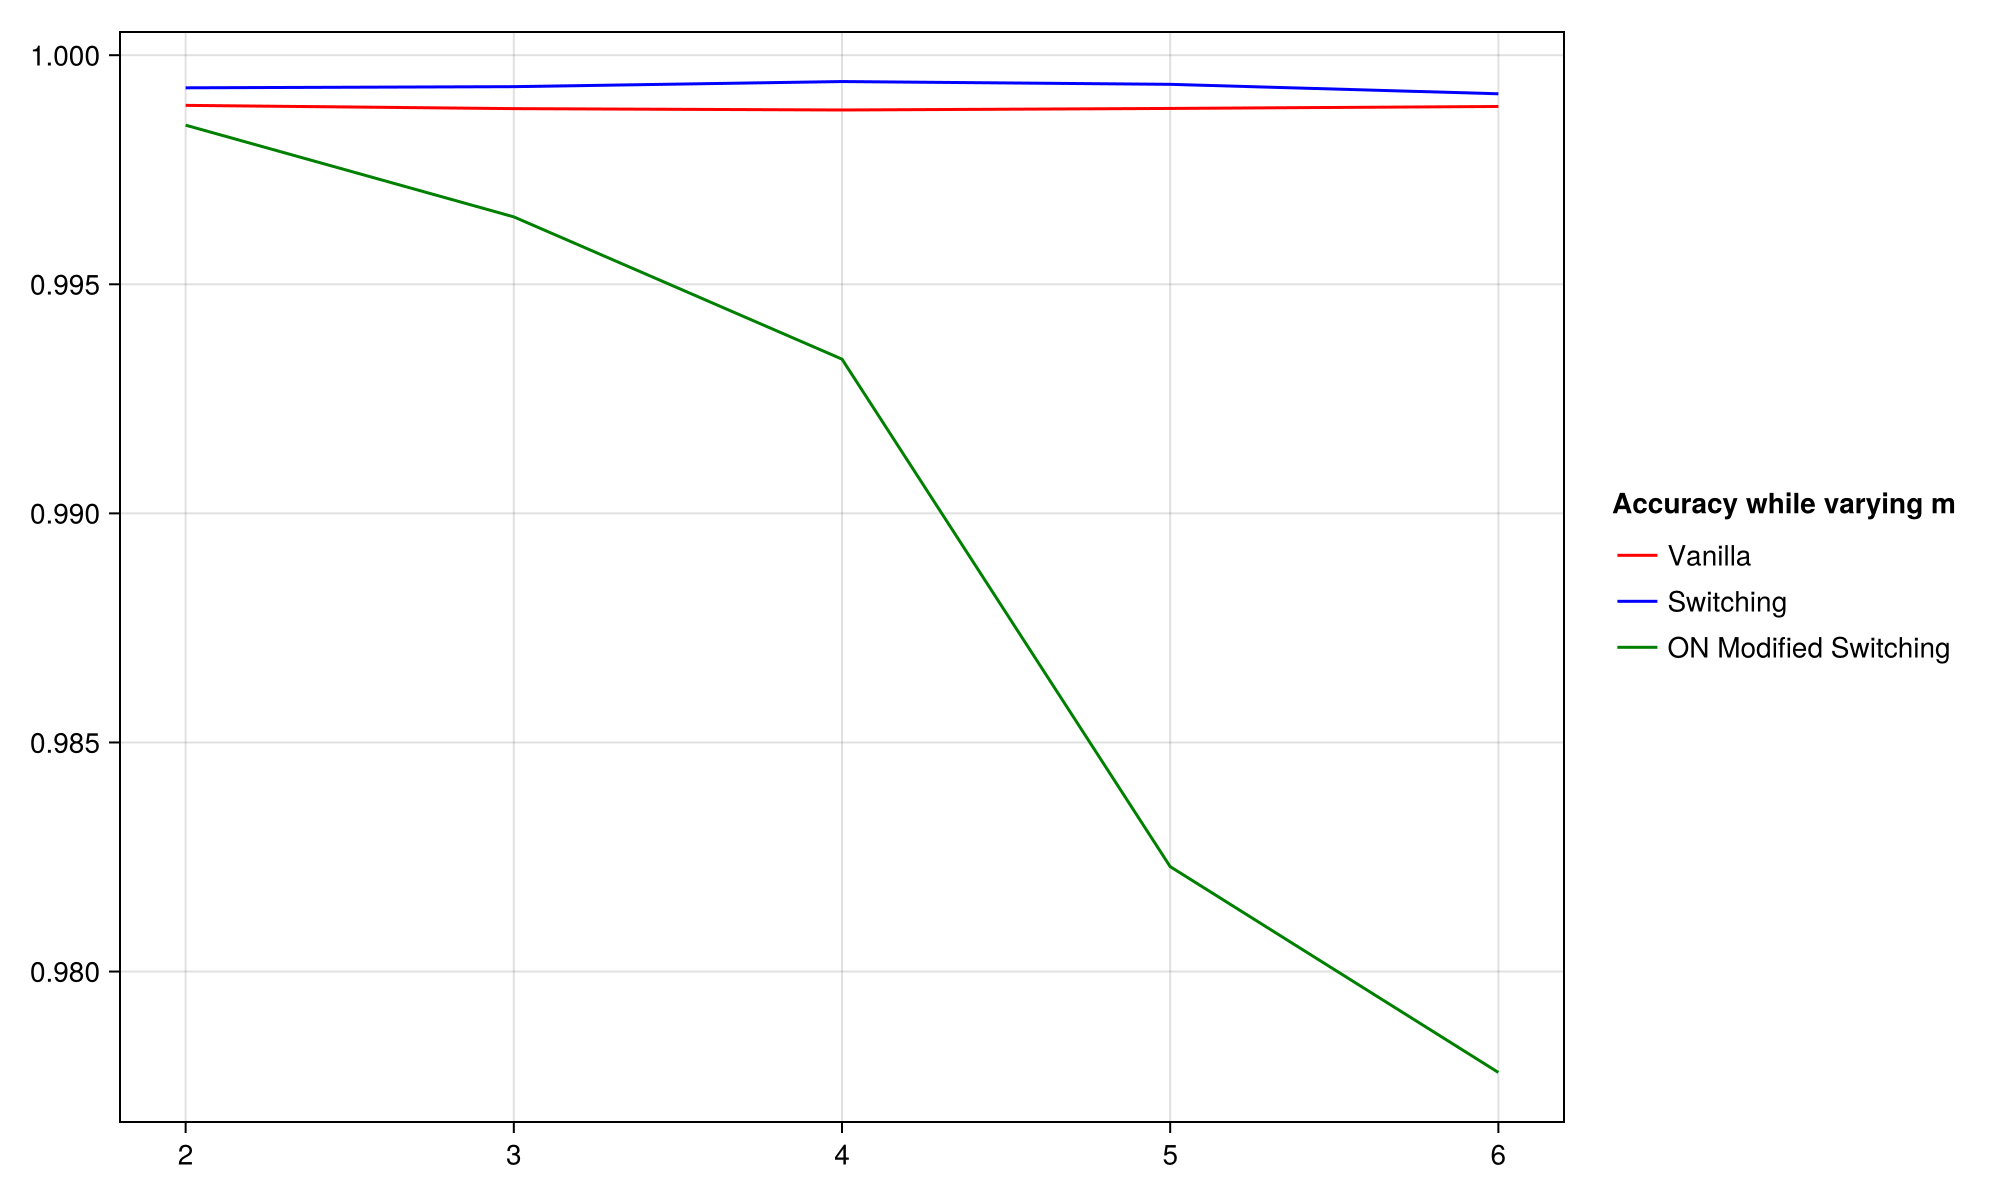

In [95]:
reproduce = 10

plot_results(
    [mean([trial_parameters(m = m) for i in 1:reproduce]) for m in 2:6],
    2:6,
    title="Accuracy while varying m"
)

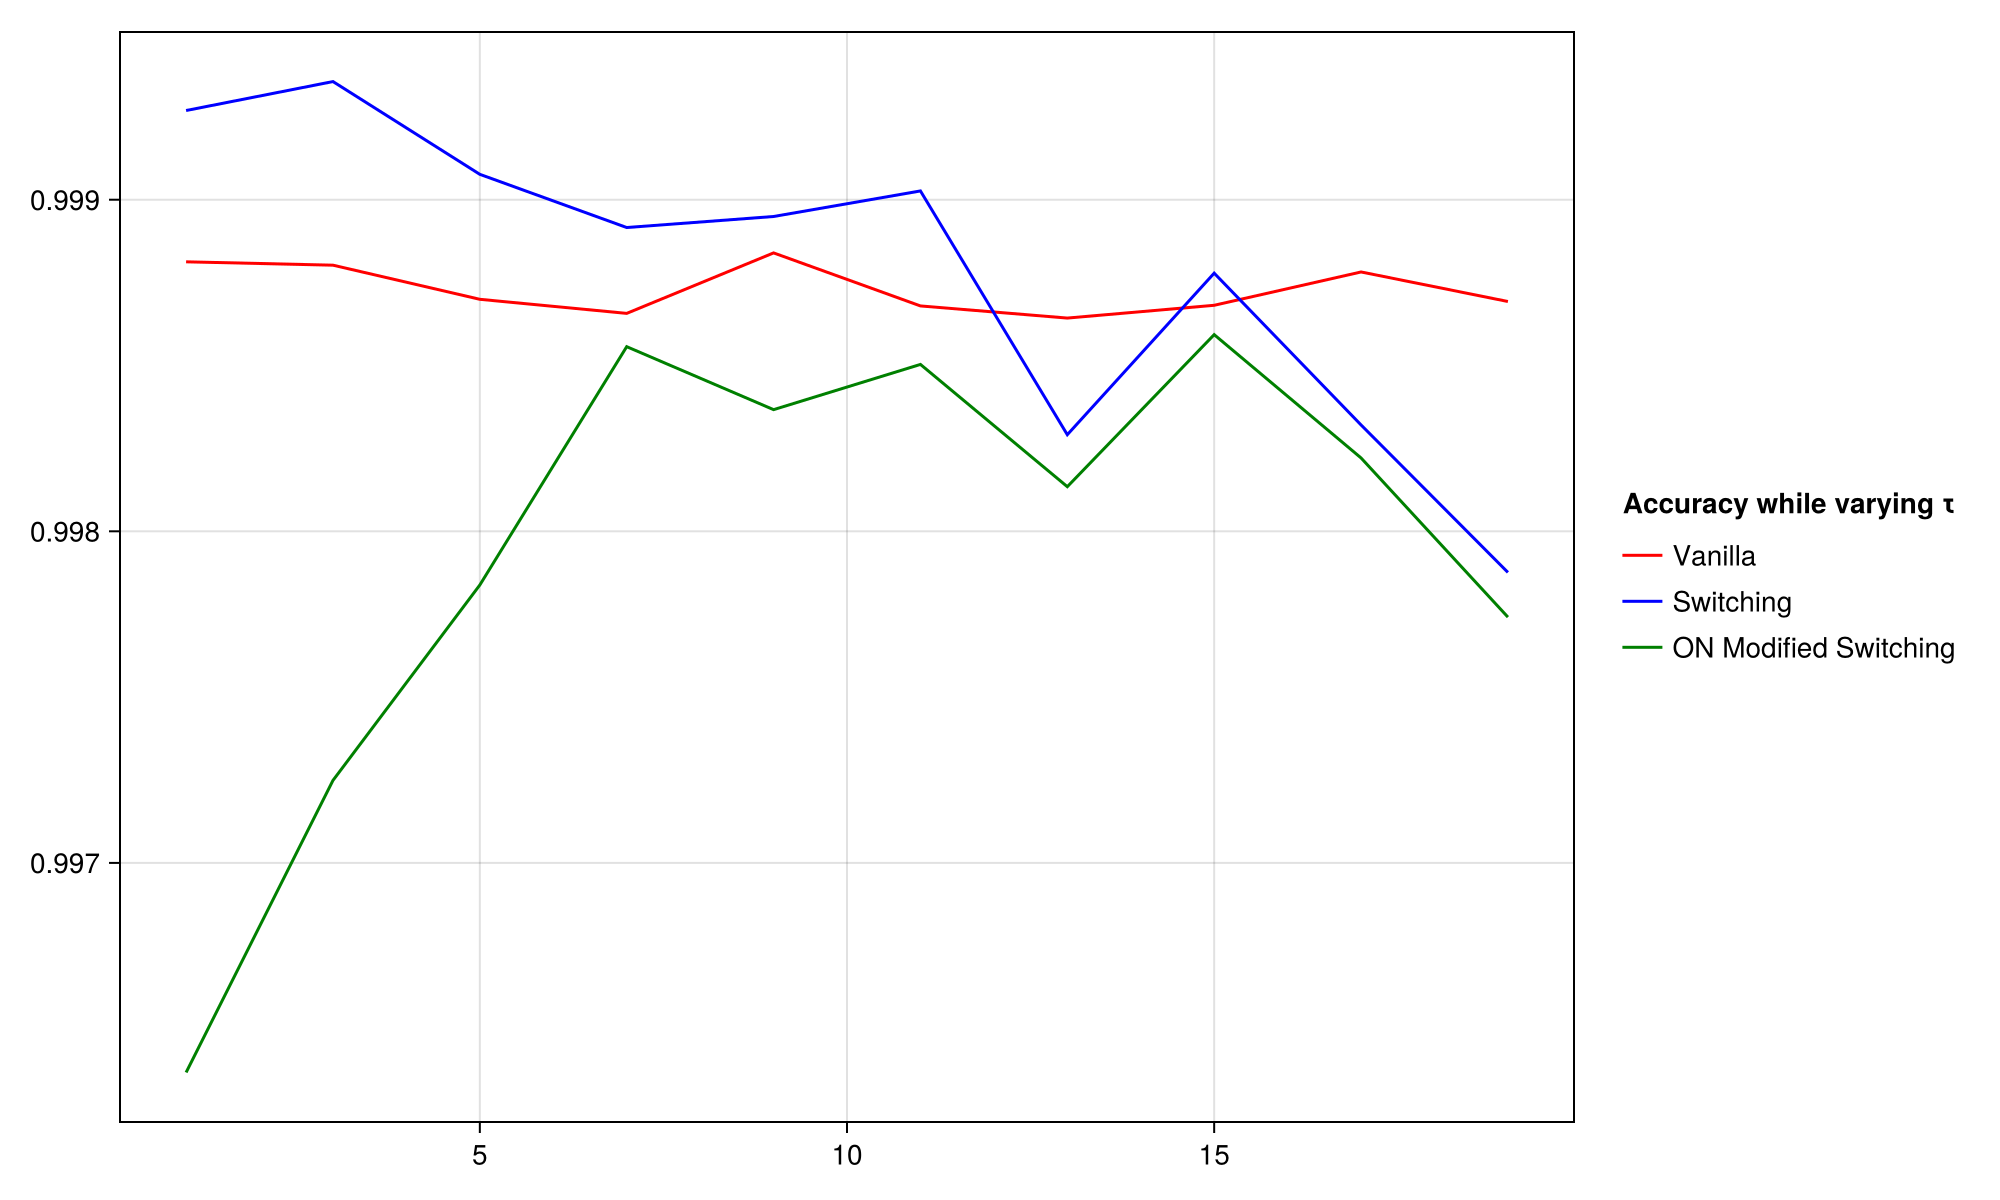

In [103]:
plot_results(
    [mean([trial_parameters(τ = τ) for i in 1:reproduce]) for τ in 1:2:20],
    1:2:20,
    title="Accuracy while varying τ"
)

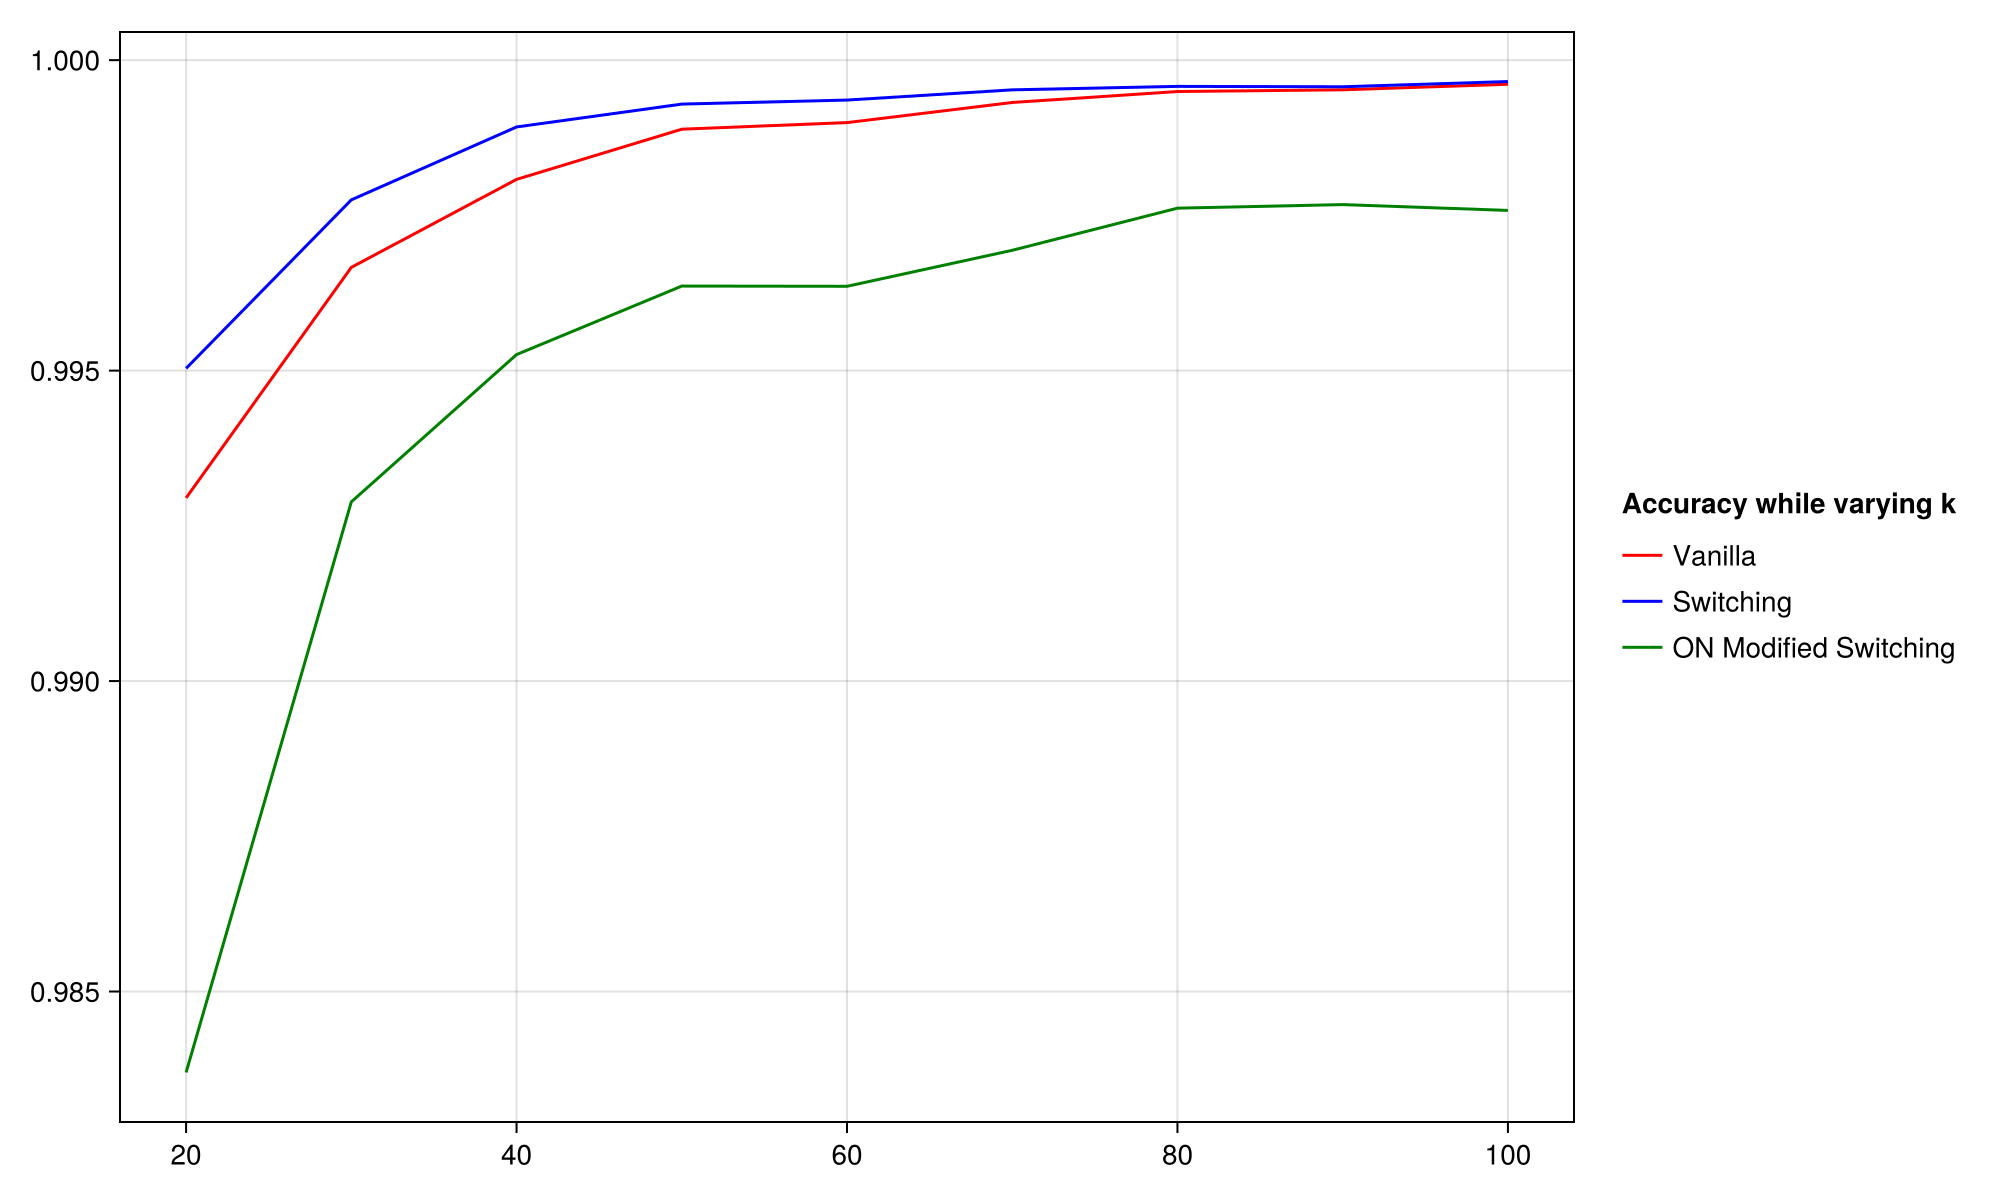

In [99]:
plot_results(
    [mean([trial_parameters(k = k) for i in 1:reproduce]) for k in 20:10:100],
    20:10:100,
    title="Accuracy while varying k"
)

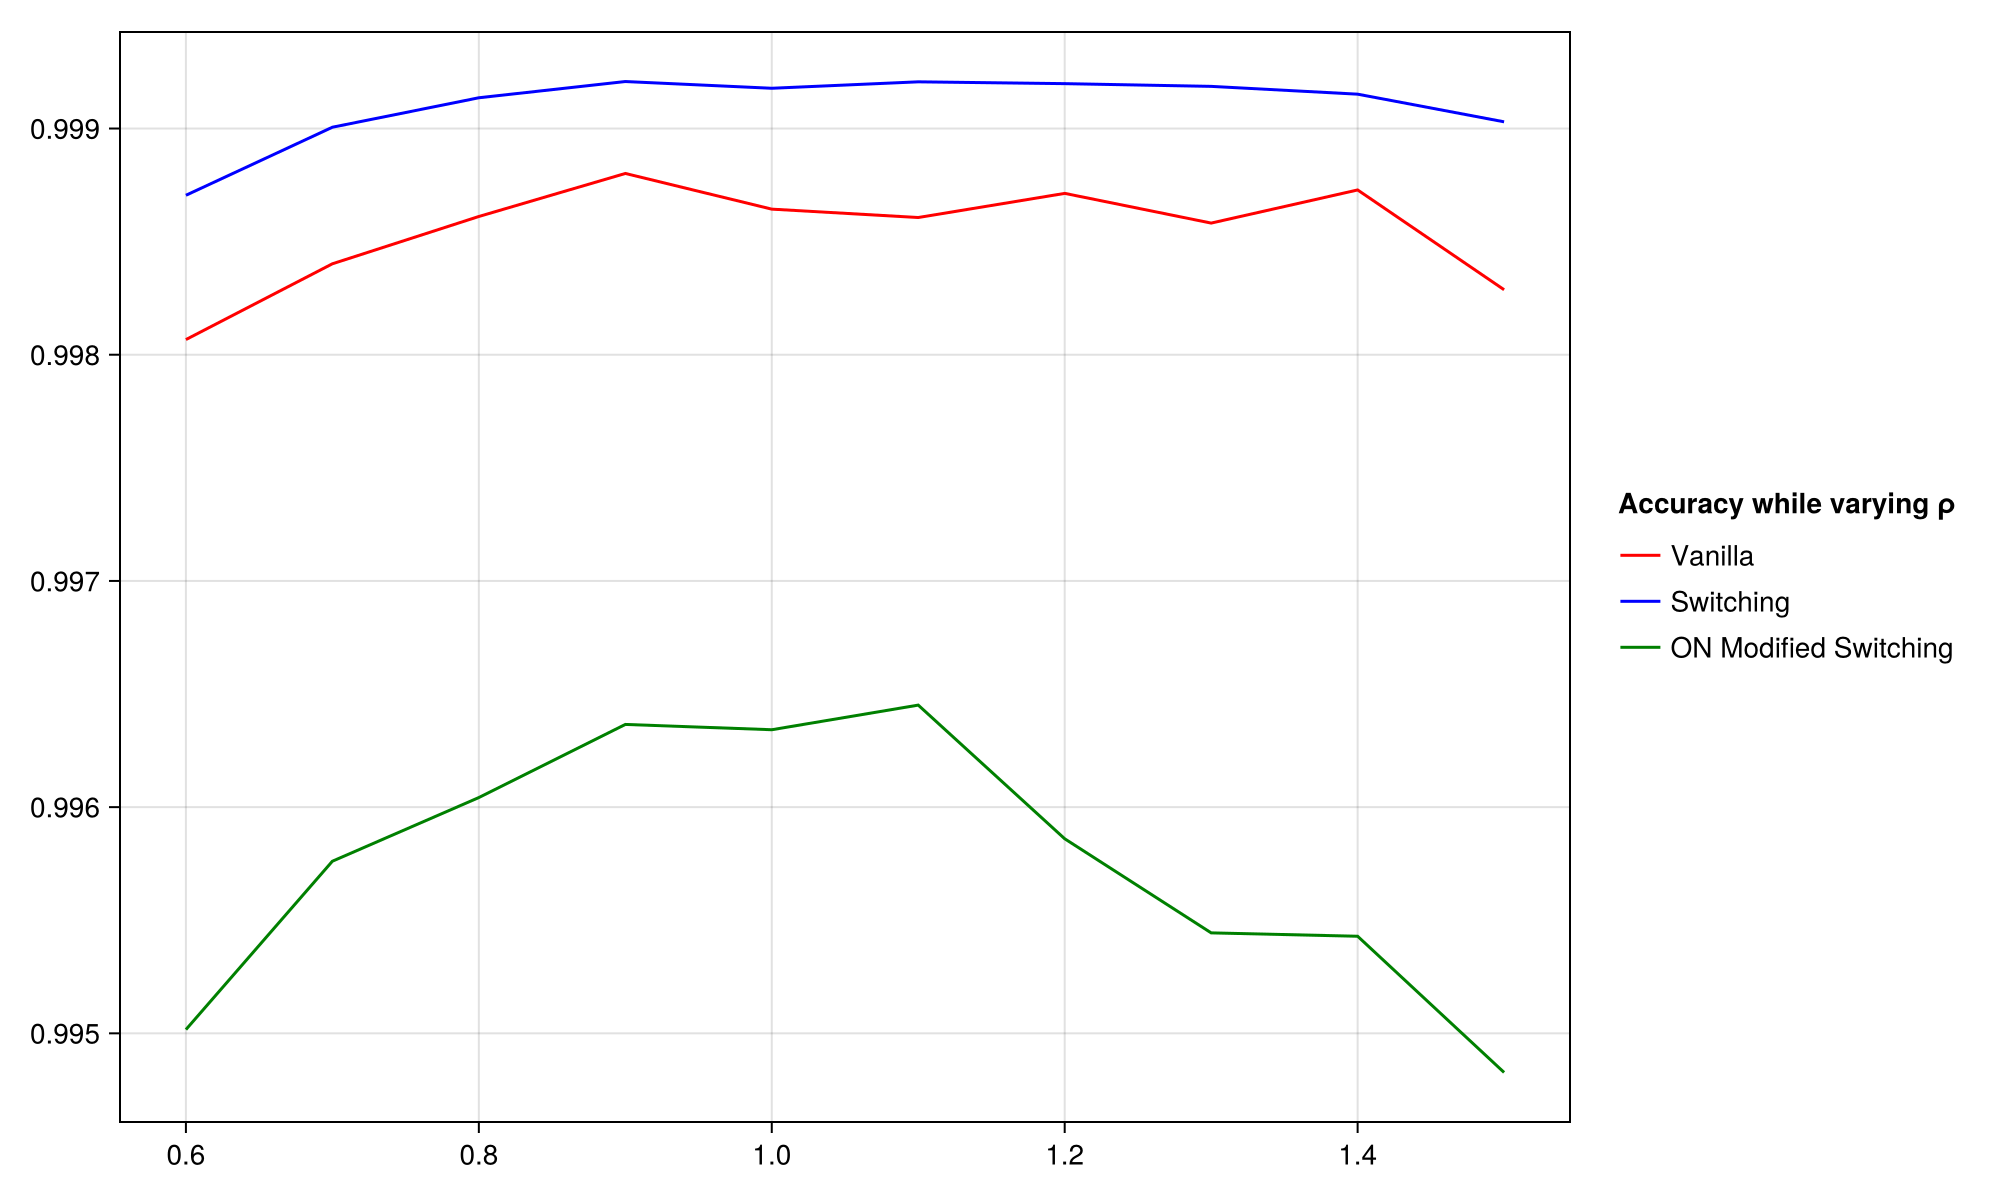

KeyError: KeyError: key "usage_request" not found

In [107]:
plot_results(
    [mean([trial_parameters(ρ = ρ) for i in 1:reproduce]) for ρ in 0.6:0.1:1.5],
    0.6:0.1:1.5,
    title="Accuracy while varying ρ"
)

Layered ESN with different reservoir for each ordinal partition. Each reservoir has the same number of nodes and the nodes will map one to one (directed) based on whether the two partitions are connected in the ordinal transition network.